finished executing


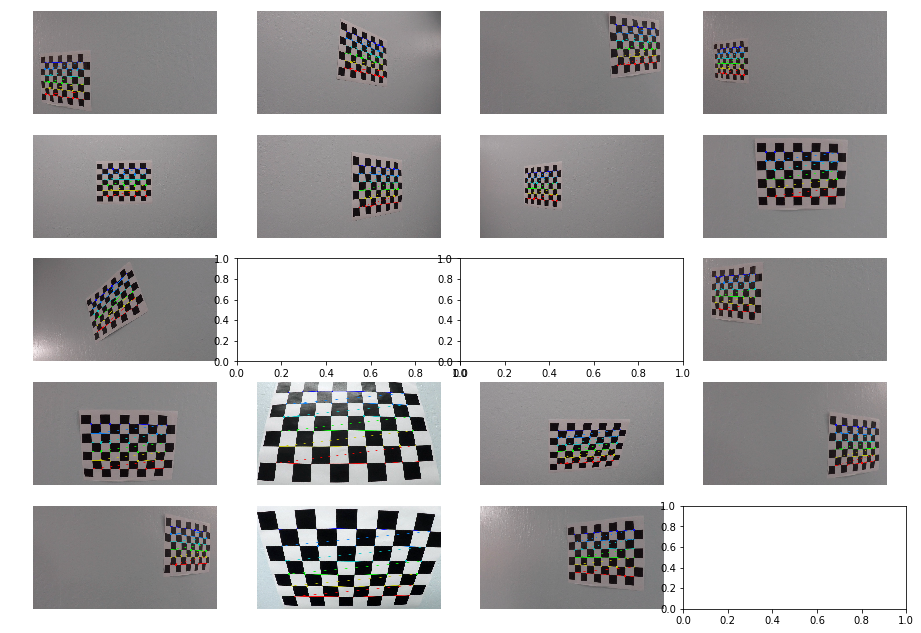

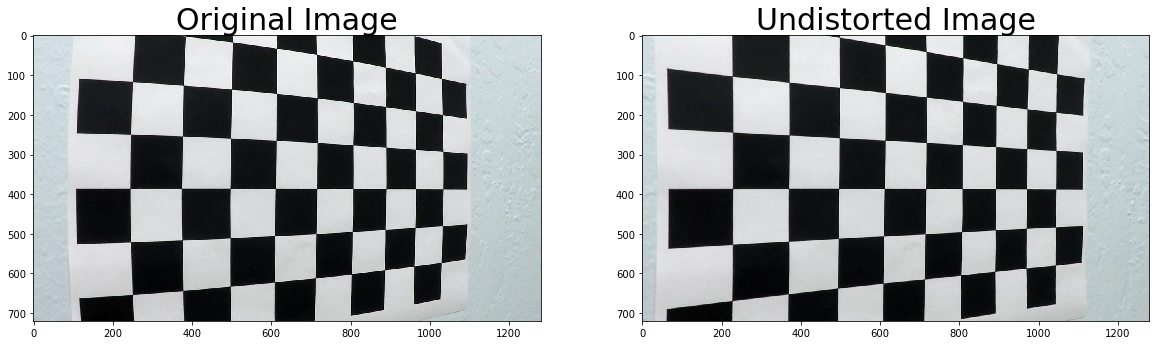

In [76]:
#custom calibration with lot of images

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt
import pickle

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        ##cv2.imshow('img', img)
        ##cv2.waitKey(500)
        axs[idx].axis('off')
        axs[idx].imshow(img)

##cv2.destroyAllWindows()

# Do camera calibration given object points and image points
# dist - distortion points. mtx - camera matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
# rvecs - rotation vector. tvecs - translation vector

dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

print ('finished executing')
# some images did not show up due to mismatch between number of rows and columns

rep-
True
dimensions
(720, 1280, 3)


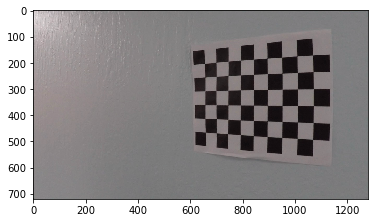

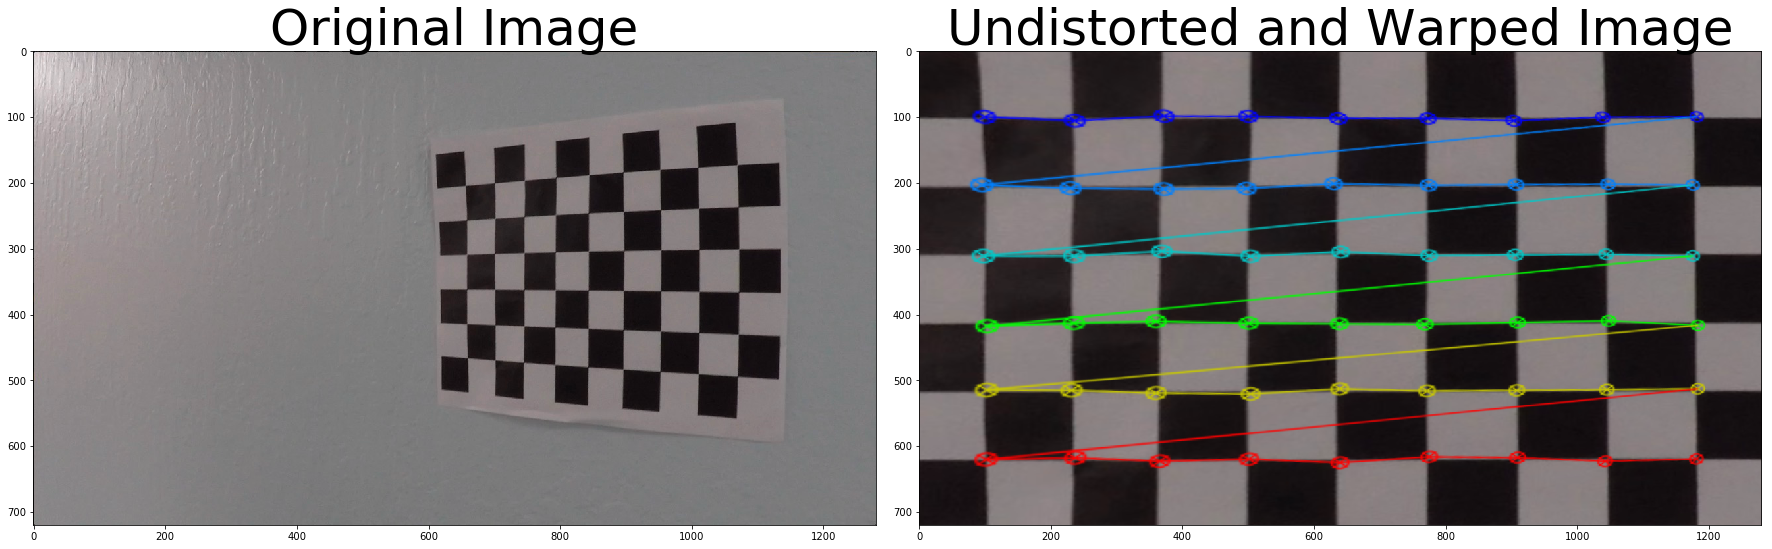

In [6]:
#here not only we are undistorting image but we are also unwarping it, which means changing its angle like we are 
# looking at it from front

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "calibration_wide/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('camera_cal/calibration12.jpg')
plt.imshow(img)
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y


def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    #plt.imshow(gray)
    print ('rep-')
    print(ret)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

        # Return the resulting image and matrix
        return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
print ('dimensions')
print (top_down.shape)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [177]:
#correcting image distortion
def warp_image(img, src, dst):
    # src and dst - source and destination point. This function is used to see an image
    # from a different angle
    """ Perspective Transform """
    h,w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src) #- for unwarping
    warp_img = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)

    return warp_img, M, Minv

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Define a function to return the magnitude of the gradient
    for a given sobel kernel size and threshold values
    """

    # adaptive histogram equalization
    # img = exposure.equalize_adapthist(img, clip_limit=0.01)

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 255

    # Return the binary image
    return binary_output

# gray scale conversion
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
# In the case of lane lines, we're interested only in edges of a particular orientation

def dir_thresh(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    """
    computes the direction of the gradient
    """
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 255
    # Return the binary image
    return binary_output.astype(np.uint8)

# additionally converting to grayscale
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def gradient_combine(img, th_x, th_y, th_mag, th_dir):
    """
    Find lane lines with gradient information of Red channel
    """
    rows, cols = img.shape[:2]
    #print('gc')
    
    R = img[220:rows - 12, 0:cols, 2]

    sobelx = sobel_xy(R, 'x', th_x)
    #cv2.imshow('sobel_x', sobelx)
    sobely = sobel_xy(R, 'y', th_y)
    #cv2.imshow('sobel_y', sobely)
    mag_img = mag_thresh(R, 3, th_mag)
    #print (mag_img.shape)
    #cv2.imshow('sobel_mag', mag_img)
    dir_img = dir_thresh(R, 15, th_dir)
    #print (dir_img.shape)
    #cv2.imshow('result5', dir_img)

    # combine gradient measurements
    gradient_comb = np.zeros_like(dir_img).astype(np.uint8)
    gradient_comb[((sobelx > 1) & (mag_img > 1) & (dir_img > 1)) | ((sobelx > 1) & (sobely > 1))] = 255

    return gradient_comb

def combine_threshold(img, th_x, th_y, th_mag, th_dir):
    """
    Find lane lines with gradient information of Red channel
    """
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    gradx = abs_sobel_thresh(img, 'x')
    #cv2.imshow('sobel_x', sobelx)
    grady = abs_sobel_thresh(img, 'y')
    #cv2.imshow('sobel_y', sobely)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
    #cv2.imshow('sobel_mag', mag_img)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))
    #cv2.imshow('result5', dir_img)

    # combine gradient measurements
        
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(img, thresh=(90, 255))


def sobel_xy(img, orient='x', thresh=(20, 100)):
    """
    Define a function that applies Sobel x or y.
    The gradient in the x-direction emphasizes edges closer to vertical.
    The gradient in the y-direction emphasizes edges closer to horizontal.
    """
    # img = exposure.equalize_hist(img)
    # adaptive histogram equalization
    # img = exposure.equalize_adapthist(img, clip_limit=0.01)

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 255

    # Return the result
    return binary_output

def ch_thresh(ch, thresh=(80, 255)):
    binary = np.zeros_like(ch)
    binary[(ch > thresh[0]) & (ch <= thresh[1])] = 255
    return binary

def hls_combine(img, th_h, th_l, th_s):
    # convert to hls color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    rows, cols = img.shape[:2]
    R = img[220:rows - 12, 0:cols, 2]
    _, R = cv2.threshold(R, 180, 255, cv2.THRESH_BINARY)
    #cv2.imshow('red!!!',R)
    H = hls[220:rows - 12, 0:cols, 0]
    L = hls[220:rows - 12, 0:cols, 1]
    S = hls[220:rows - 12, 0:cols, 2]

    h_img = ch_thresh(H, th_h)
    #cv2.imshow('HLS (H) threshold', h_img)
    l_img = ch_thresh(L, th_l)
    #cv2.imshow('HLS (L) threshold', l_img)
    s_img = ch_thresh(S, th_s)
    #cv2.imshow('HLS (S) threshold', s_img)

    # Two cases - lane lines in shadow or not
    hls_comb = np.zeros_like(s_img).astype(np.uint8)
    hls_comb[((s_img > 1) & (l_img == 0)) | ((s_img == 0) & (h_img > 1) & (l_img > 1))] = 255 # | (R > 1)] = 255
    #hls_comb[((s_img > 1) & (h_img > 1)) | (R > 1)] = 255
    return hls_comb

def comb_result(grad, hls):
    """ give different value to distinguish them """
    result = np.zeros_like(hls).astype(np.uint8)
    #result[((grad > 1) | (hls > 1))] = 255
    result[(grad > 1)] = 100
    result[(hls > 1)] = 255

    return result

def undistort(img, mtx, dist):
    """ undistort image """
    return cv2.undistort(img, mtx, dist, None, mtx)


print ('functions created')

functions created


Testing Mag Gradient


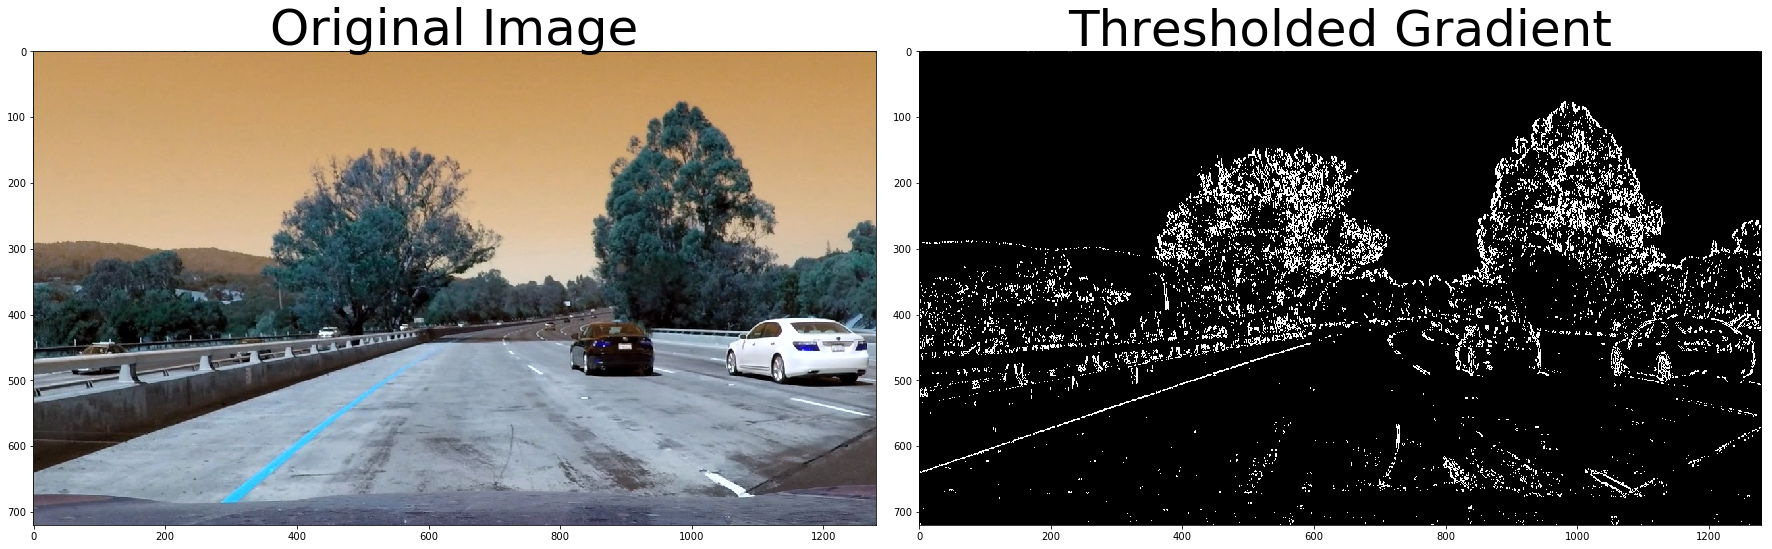

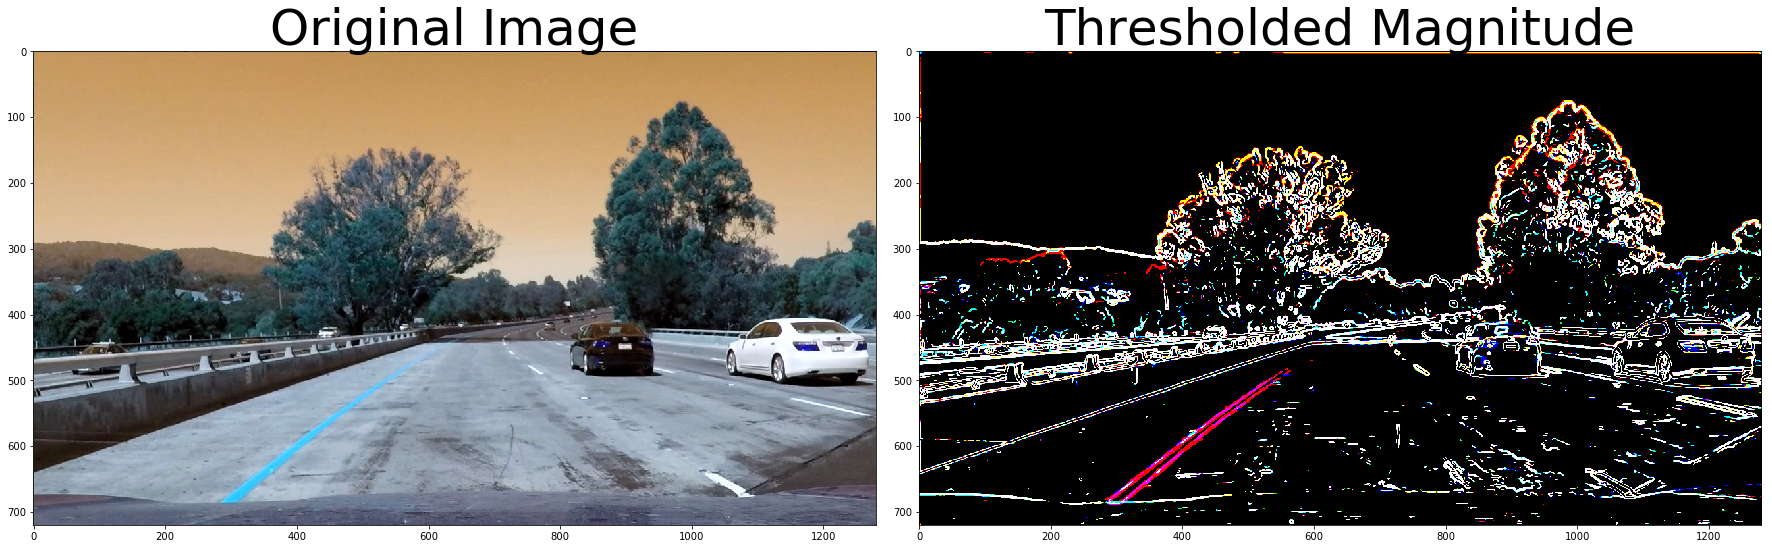

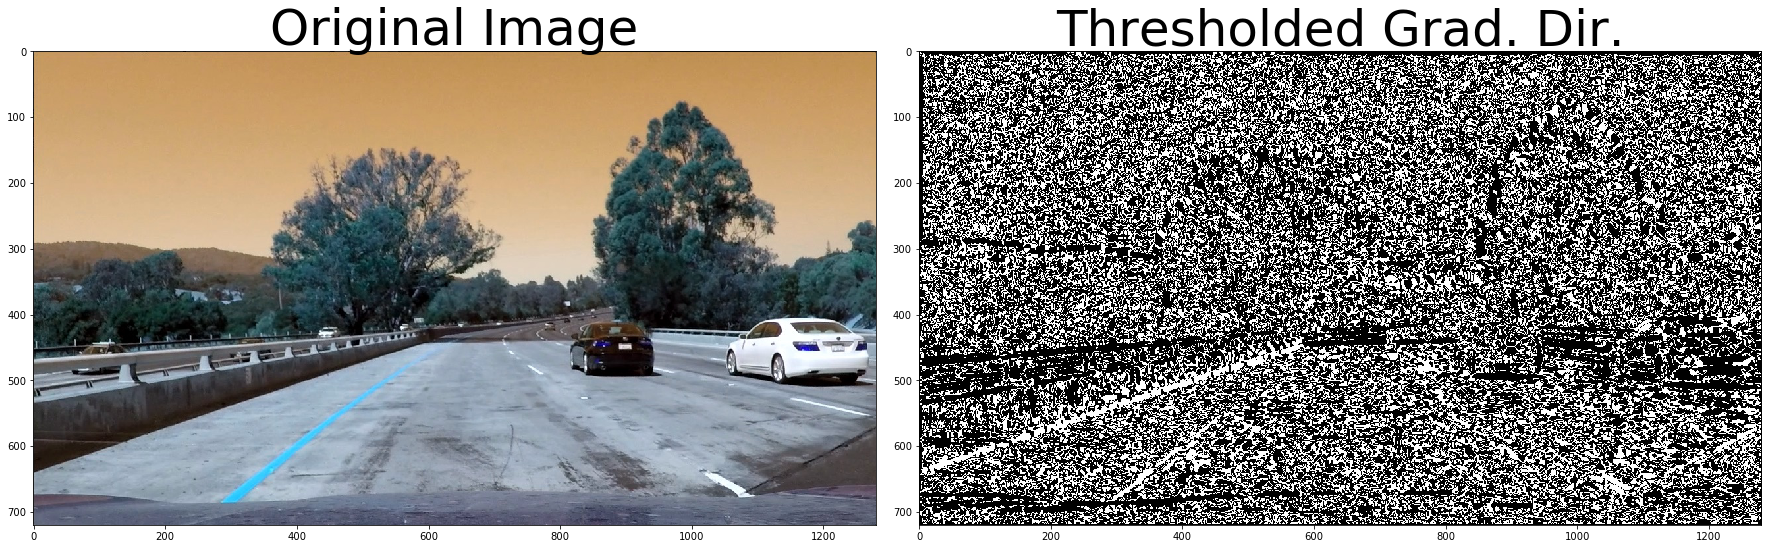

In [11]:
#testing sobel

img = cv2.imread('test_images/test1.jpg')
#grad_binary = abs_sobel_thresh(img)

# Run the function
grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


print('Testing Mag Gradient')

#mag_bin = mag_thresh(img, 9, mag_thresh=(30, 100))
mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Run the function
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

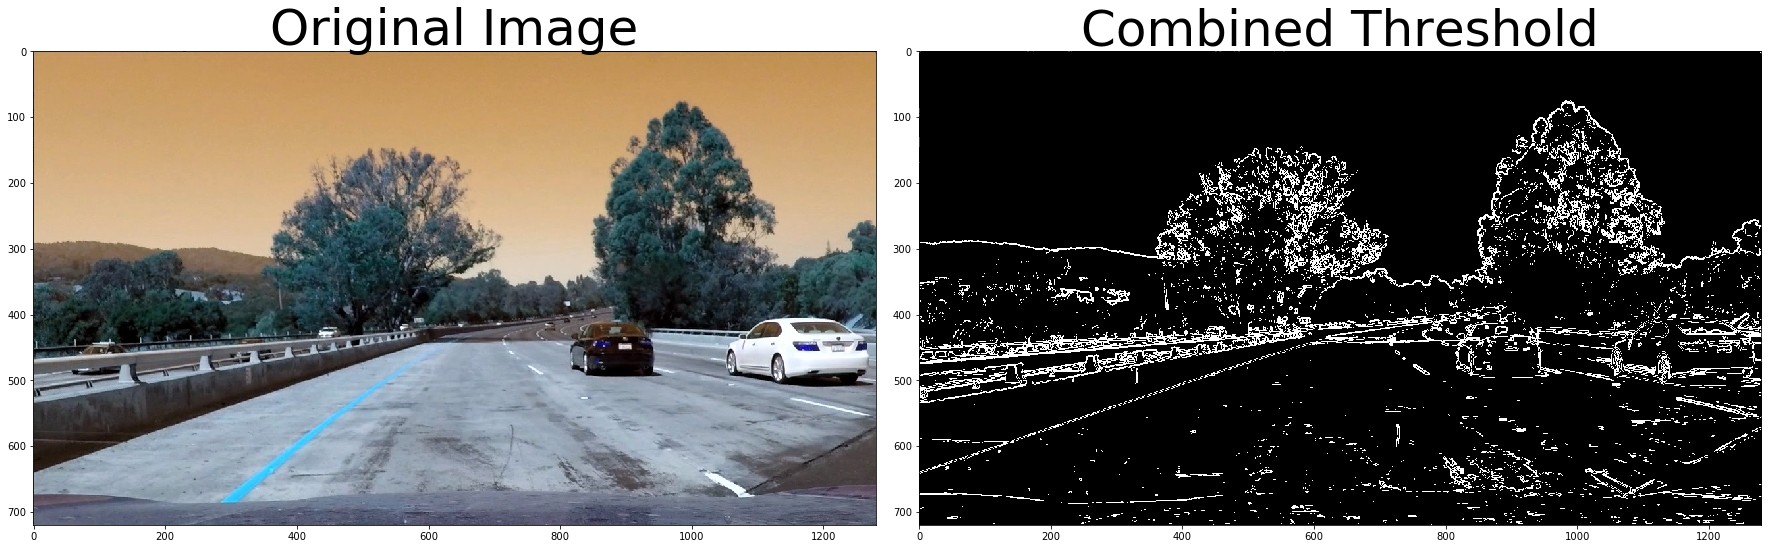

In [14]:
#combined test

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
#abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255)
gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
mag_binary = mag_threshold(img, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

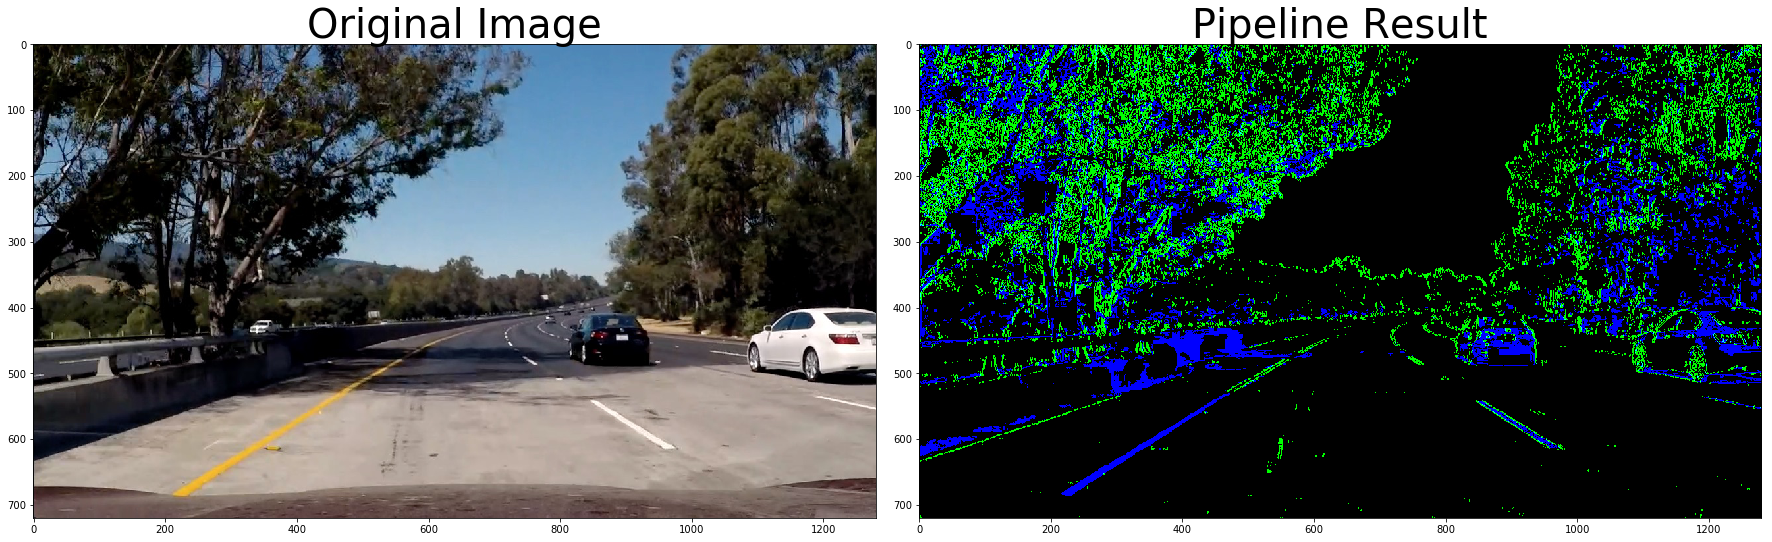

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread('bridge_shadow.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

here
(720, 1280, 3)
gc
(488, 1280)
(488, 1280)
here c
(488, 1280)
(488, 1280)
(720, 1280)
[640.0, 360.0] [664.0, 360.0]
[250, 720] [1170, 720]


/home/mandeep/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


here 2
(720, 1280, 3)
(720, 1280, 3)


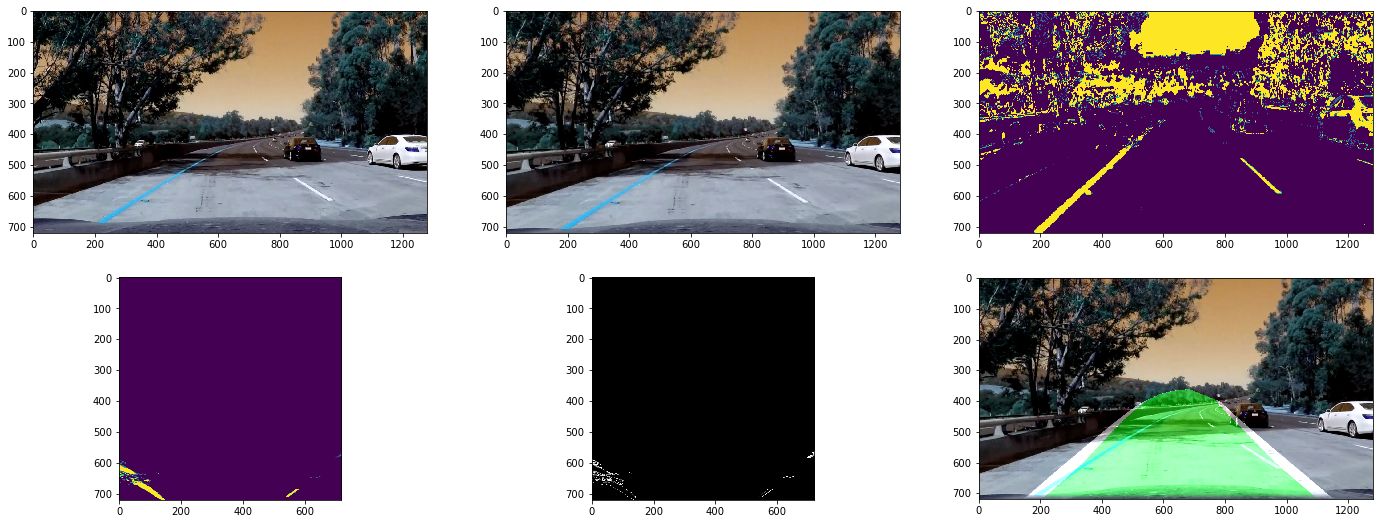

In [151]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

th_sobelx, th_sobely, th_mag, th_dir = (35, 100), (30, 255), (30, 255), (0.7, 1.3)
th_h, th_l, th_s = (10, 100), (0, 60), (85, 255)

#axis = plt.subplot(1,5, figsize=(5, 5))
fig, axis = plt.subplots(2,3, figsize=(24, 9))
#fig.subplots_adjust(hspace = 1, wspace=1)
#axis = axis.ravel()

img = cv2.imread('bridge_shadow.jpg')
#cv2.imshow('img',img)
axis[0,0].imshow(img)
undist_img = undistort(img, mtx, dist)
print ('here')
print (undist_img.shape)
#undist_img = cv2.resize(undist_img, None, fx=1 / 2, fy=1 / 2, interpolation=cv2.INTER_AREA)
#print (undist_img.shape)
axis[0,1].imshow(undist_img)
rows, cols = undist_img.shape[:2]

combined_gradient = gradient_combine(undist_img, th_sobelx, th_sobely, th_mag, th_dir)
print ('here c')
print (combined_gradient.shape)
combined_hls = hls_combine(undist_img, th_h, th_l, th_s)

print (combined_hls.shape)
combined_result = comb_result(combined_gradient, combined_hls)
combined_result = cv2.resize(combined_result, (undist_img.shape[1], undist_img.shape[0]))
print (combined_result.shape)
#combined_result = threshold(undist_img)
axis[0,2].imshow(combined_result)
c_rows, c_cols = combined_result.shape[:2]


s_LTop2, s_RTop2 = [c_cols / 2, c_rows / 2], [c_cols / 2 + 24, c_rows / 2]
s_LBot2, s_RBot2 = [250, c_rows], [c_cols - 110, c_rows]


print (s_LTop2, s_RTop2)
print (s_LBot2, s_RBot2)

src = np.float32([s_LBot2, s_LTop2, s_RTop2, s_RBot2])
dst = np.float32([(170, 720), (170, 0), (550, 0), (550, 720)])

warp_img, M, Minv = warp_image(combined_result, src, dst, (720, 720))

binary_warped = warp_img
axis[1,0].imshow(binary_warped)

def sliding_windows():

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    axis[1,1].imshow(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
        

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    #print (left_lane_inds)
    #print (right_lane_inds)
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    left_fit = left_lane_inds
    right_fit = right_lane_inds
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    #print (lefty)
    #print (righty)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!

    '''nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]'''


    # Create an image to draw on and an image to show the selection window
    '''out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    #out_img = np.dstack((undist_img, undist_img, undist_img))
    #window_img = np.zeros_like(out_img)
        
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)'''
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #color_warp = np.zeros_like(img).astype(np.uint8)

    h,w = binary_warped.shape
    ploty = np.linspace(0, h-1, num=h) # to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #print (right_fitx, left_fitx)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])    

    pts = np.hstack((pts_left, pts_right))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    print ('here 2')
    print (newwarp.shape)
    print (undist_img.shape)
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.5, 0)
    plt.imshow(result)
    
    '''warped = binary_warped
    undist = undist_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    print (Minv.shape)
    print (warped.shape)
    print(img.shape)
    print (color_warp.shape)
    print (undist.shape)
    print (newwarp.shape)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result) '''
    
    '''binary_img = binary_warped
    new_img = np.copy(img)
    #if l_fit is None or r_fit is None:
    #    return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    plt.imshow(result)'''
    
    '''img = undist_img
    color_warp = np.zeros_like(img).astype(np.uint8)

    fity = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
    right_fitx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, fity])))])
    pts = np.hstack((pts_left, pts_right))
    pts = np.array(pts, dtype=np.int32)

    cv2.fillPoly(color_warp, pts, (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0) 
    
    axis[1,2].imshow(result)'''
    
sliding_windows()

In [179]:

# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output


# Define a function that thresholds the B-channel of LAB
# Use exclusive lower bound (>) and inclusive upper (<=), OR the results of the thresholds (B channel should capture
# yellows)
def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [181]:
def finalPipeline(img):
    undist_img = undistort(img, mtx, dist)
        
    h,w = undist_img.shape[:2]

    # define source and destination points for transform
    src = np.float32([(575,464),
                      (707,464), 
                      (258,682), 
                      (1049,682)])
    dst = np.float32([(450,0),
                      (w-450,0),
                      (450,h),
                      (w-450,h)])
    
    warp_img, M, Minv = warp_image(undist_img, src, dst)
    
    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_lthresh(warp_img)

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(warp_img)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    return combined, Minv

print ('function created')

function created


In [185]:
def finalPipeline2(img):
    
    th_sobelx, th_sobely, th_mag, th_dir = (35, 100), (30, 255), (30, 255), (0.7, 1.3)
    th_h, th_l, th_s = (10, 100), (0, 60), (85, 255)
    
    undist_img = undistort(img, mtx, dist)
        
    h,w = undist_img.shape[:2]

    # define source and destination points for transform
    src = np.float32([(575,464),
                      (707,464), 
                      (258,682), 
                      (1049,682)])
    dst = np.float32([(450,0),
                      (w-450,0),
                      (450,h),
                      (w-450,h)])
    
    warp_img, M, Minv = warp_image(undist_img, src, dst)
    
    combined_gradient = gradient_combine(warp_img, th_sobelx, th_sobely, th_mag, th_dir)
    #print ('here c')
    #print (combined_gradient.shape)
    combined_hls = hls_combine(warp_img, th_h, th_l, th_s)

    #print (combined_hls.shape)
    combined_result = comb_result(combined_gradient, combined_hls)
    combined_result = cv2.resize(combined_result, (undist_img.shape[1], undist_img.shape[0]))
    
    
    
    return combined_result, Minv

print ('function created')

function created


done


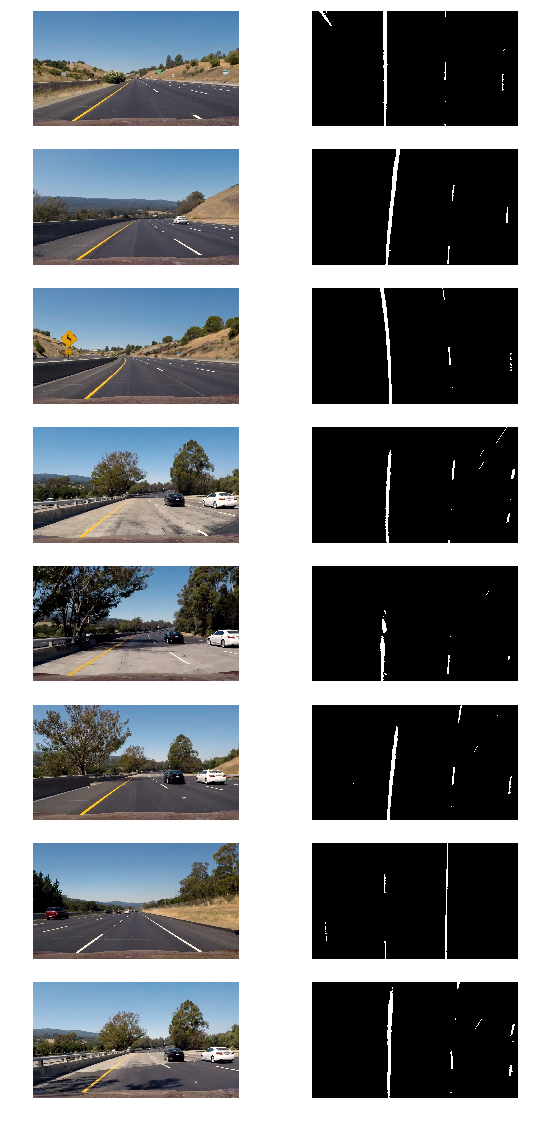

In [187]:
# Load example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = finalPipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

print('done')

In [188]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

print('executed')

executed


In [189]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

print('executed')

executed


In [240]:
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist
print('...')

...


In [247]:
def measuringCurvature(ploty, leftx, rightx, lefty, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return (left_curverad, right_curverad)    
    
print('executed')
    

executed


In [223]:
def draw_data(orig_img, curv_rad):    
    h = orig_img.shape[0]
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(orig_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)    
    return orig_img

print('executed')

executed


1200.61476469 m 588.691009526 m
test curv
(1200.6147646928075, 588.69100952636586, -0.1354697868644168)
1200.61476469
588.691009526
894.65288711


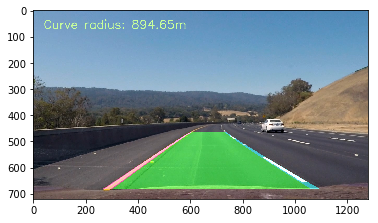

In [248]:
# visualize the result on example image
exampleImg2 = cv2.imread('./test_images/test3.jpg')
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_bin, Minv = finalPipeline(exampleImg2) 

left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg2_bin)

h,w = img_bin.shape
ploty = np.linspace(0, h-1, num=h)
#print (ploty)

img_out1 = draw_lane(exampleImg2, exampleImg2_bin, left_fit, right_fit, Minv)

nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

(left_curve, right_curve) = measuringCurvature(ploty, leftx, rightx, lefty, righty)

img_out1 = draw_data(img_out1, float((left_curve + right_curve)/2))
    
plt.imshow(img_out1)

1200.61476469 m 588.691009526 m


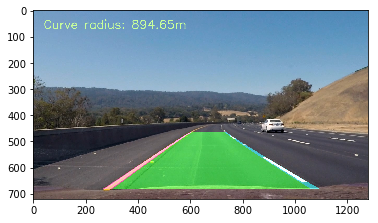

In [256]:
plt.imshow(process_image(cv2.imread('./test_images/test3.jpg')))

In [257]:
def process_image(img):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = finalPipeline(img)
    
    
    l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
            
   
    img_out1 = draw_lane(img, img_bin, l_fit, r_fit, Minv)
    
    h,w = img_bin.shape[0], img_bin.shape[1]
    nonzero = img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    ploty = np.linspace(0, h-1, num=h)
    
    (left_curve, right_curve) = measuringCurvature(ploty, leftx, rightx, lefty, righty)
    img_out1 = draw_data(img_out1, (left_curve + right_curve)/2)
    return img_out1

print('executed')

executed


In [258]:
from moviepy.editor import VideoFileClip

#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

464.540931231 m 532.522166546 m
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



  0%|          | 1/1261 [00:00<07:45,  2.71it/s]

464.540931231 m 532.522166546 m



  0%|          | 2/1261 [00:00<08:17,  2.53it/s]

436.3177718 m 545.515059076 m



  0%|          | 3/1261 [00:01<08:05,  2.59it/s]

420.731019023 m 548.30645792 m



  0%|          | 4/1261 [00:01<08:56,  2.34it/s]

385.739281094 m 532.605302464 m



  0%|          | 5/1261 [00:02<09:24,  2.23it/s]

384.14242162 m 510.6452048 m



  0%|          | 6/1261 [00:02<09:00,  2.32it/s]

386.581348887 m 484.407171883 m



  1%|          | 7/1261 [00:02<08:30,  2.46it/s]

404.738007489 m 492.657534355 m



  1%|          | 8/1261 [00:03<07:59,  2.62it/s]

392.796574181 m 677.274917485 m



  1%|          | 9/1261 [00:03<09:06,  2.29it/s]

392.926366808 m 687.257815435 m



  1%|          | 10/1261 [00:04<09:28,  2.20it/s]

402.114000179 m 710.036253117 m



  1%|          | 11/1261 [00:05<11:15,  1.85it/s]

424.916708145 m 749.022295985 m



  1%|          | 12/1261 [00:05<10:44,  1.94it/s]

453.494287394 m 783.824984206 m



  1%|          | 13/1261 [00:05<09:56,  2.09it/s]

487.371290161 m 826.82778288 m



  1%|          | 14/1261 [00:06<08:57,  2.32it/s]

522.486121333 m 713.714245975 m



  1%|          | 15/1261 [00:06<10:15,  2.03it/s]

551.579387297 m 746.690802358 m



  1%|▏         | 16/1261 [00:07<10:05,  2.06it/s]

572.939360078 m 699.205273404 m



  1%|▏         | 17/1261 [00:07<09:32,  2.17it/s]

592.680436707 m 614.567262057 m



  1%|▏         | 18/1261 [00:08<09:01,  2.29it/s]

646.433617189 m 696.282198385 m



  2%|▏         | 19/1261 [00:08<08:58,  2.30it/s]

739.144904299 m 715.913652229 m



  2%|▏         | 20/1261 [00:08<08:31,  2.43it/s]

826.162888897 m 749.966453706 m



  2%|▏         | 21/1261 [00:09<11:21,  1.82it/s]

947.975054131 m 765.359006903 m



  2%|▏         | 22/1261 [00:10<10:22,  1.99it/s]

995.503276094 m 744.284507577 m



  2%|▏         | 23/1261 [00:10<11:40,  1.77it/s]

885.117016114 m 738.189046601 m



  2%|▏         | 24/1261 [00:11<11:23,  1.81it/s]

832.721248546 m 726.13774422 m



  2%|▏         | 25/1261 [00:11<10:56,  1.88it/s]

761.781718468 m 478.954274453 m



  2%|▏         | 26/1261 [00:12<09:51,  2.09it/s]

738.005547104 m 525.138774749 m



  2%|▏         | 27/1261 [00:12<08:44,  2.35it/s]

666.608446988 m 515.954053539 m



  2%|▏         | 28/1261 [00:12<08:38,  2.38it/s]

688.115661612 m 518.467952187 m



  2%|▏         | 29/1261 [00:13<09:10,  2.24it/s]

623.771980848 m 524.799172221 m



  2%|▏         | 30/1261 [00:14<10:47,  1.90it/s]

507.933693081 m 466.40712759 m



  2%|▏         | 31/1261 [00:14<09:54,  2.07it/s]

468.24371904 m 451.910665612 m



  3%|▎         | 32/1261 [00:14<09:23,  2.18it/s]

438.251623869 m 480.110331178 m



  3%|▎         | 33/1261 [00:15<09:01,  2.27it/s]

443.684714838 m 659.905122062 m



  3%|▎         | 34/1261 [00:15<08:28,  2.41it/s]

417.639301185 m 636.977120516 m



  3%|▎         | 35/1261 [00:16<08:04,  2.53it/s]

394.703385077 m 592.644473378 m



  3%|▎         | 36/1261 [00:16<09:25,  2.17it/s]

373.996241154 m 629.780194831 m



  3%|▎         | 37/1261 [00:17<11:07,  1.83it/s]

364.835240966 m 610.142030042 m



  3%|▎         | 38/1261 [00:17<10:07,  2.01it/s]

345.551262123 m 494.29453969 m



  3%|▎         | 39/1261 [00:18<10:56,  1.86it/s]

327.114088747 m 500.062902599 m



  3%|▎         | 40/1261 [00:19<12:22,  1.64it/s]

324.828553072 m 512.82687469 m



  3%|▎         | 41/1261 [00:19<13:02,  1.56it/s]

330.389169984 m 501.496820964 m



  3%|▎         | 42/1261 [00:20<11:17,  1.80it/s]

317.396774145 m 478.175991163 m



  3%|▎         | 43/1261 [00:20<11:53,  1.71it/s]

321.72497941 m 449.729119686 m



  3%|▎         | 44/1261 [00:21<10:27,  1.94it/s]

324.627373211 m 453.224200906 m



  4%|▎         | 45/1261 [00:21<10:32,  1.92it/s]

327.567717873 m 465.020684568 m



  4%|▎         | 46/1261 [00:22<11:18,  1.79it/s]

337.84694269 m 535.90129656 m



  4%|▎         | 47/1261 [00:22<10:12,  1.98it/s]

344.801121717 m 531.831643126 m



  4%|▍         | 48/1261 [00:23<09:19,  2.17it/s]

349.868862834 m 549.050220342 m



  4%|▍         | 49/1261 [00:23<09:20,  2.16it/s]

381.713918371 m 540.10568979 m



  4%|▍         | 50/1261 [00:24<11:36,  1.74it/s]

401.035985524 m 532.036401901 m



  4%|▍         | 51/1261 [00:24<10:15,  1.97it/s]

426.070610669 m 451.772063455 m



  4%|▍         | 52/1261 [00:25<09:23,  2.15it/s]

460.407879561 m 406.318899911 m



  4%|▍         | 53/1261 [00:25<09:31,  2.11it/s]

487.051140837 m 447.720725724 m



  4%|▍         | 54/1261 [00:26<08:44,  2.30it/s]

527.108569896 m 458.901983473 m



  4%|▍         | 55/1261 [00:26<08:01,  2.51it/s]

609.498212827 m 390.508221783 m



  4%|▍         | 56/1261 [00:26<07:43,  2.60it/s]

688.416696719 m 383.684458898 m



  5%|▍         | 57/1261 [00:27<07:21,  2.73it/s]

766.823870109 m 442.752306678 m



  5%|▍         | 58/1261 [00:27<07:05,  2.83it/s]

808.396806898 m 568.67093143 m



  5%|▍         | 59/1261 [00:27<08:12,  2.44it/s]

792.537001025 m 616.624678111 m



  5%|▍         | 60/1261 [00:28<07:55,  2.52it/s]

754.322542554 m 604.342115121 m



  5%|▍         | 61/1261 [00:29<10:54,  1.83it/s]

675.489026778 m 590.273176065 m



  5%|▍         | 62/1261 [00:29<09:57,  2.01it/s]

598.835139796 m 581.062668085 m



  5%|▍         | 63/1261 [00:29<08:58,  2.22it/s]

579.759330312 m 567.394334598 m



  5%|▌         | 64/1261 [00:30<09:24,  2.12it/s]

517.121751569 m 512.898901923 m



  5%|▌         | 65/1261 [00:30<08:51,  2.25it/s]

481.694313486 m 599.132012049 m



  5%|▌         | 66/1261 [00:31<10:06,  1.97it/s]

472.11140677 m 570.045848452 m



  5%|▌         | 67/1261 [00:31<09:23,  2.12it/s]

480.474773728 m 594.349641379 m



  5%|▌         | 68/1261 [00:32<08:46,  2.26it/s]

456.365945179 m 566.798419078 m



  5%|▌         | 69/1261 [00:32<08:20,  2.38it/s]

440.706897291 m 679.275179305 m



  6%|▌         | 70/1261 [00:32<07:27,  2.66it/s]

448.164761488 m 741.554387871 m



  6%|▌         | 71/1261 [00:33<07:26,  2.66it/s]

450.722822466 m 1075.40350089 m



  6%|▌         | 72/1261 [00:33<07:08,  2.77it/s]

483.711993891 m 1123.30090578 m



  6%|▌         | 73/1261 [00:34<07:36,  2.60it/s]

548.137460893 m 1015.16635945 m



  6%|▌         | 74/1261 [00:34<07:25,  2.66it/s]

621.804792001 m 1030.47651226 m



  6%|▌         | 75/1261 [00:34<07:10,  2.76it/s]

732.732766446 m 641.233104322 m



  6%|▌         | 76/1261 [00:34<06:38,  2.97it/s]

868.953035033 m 606.961503487 m



  6%|▌         | 77/1261 [00:35<06:19,  3.12it/s]

1074.03345166 m 593.64516453 m



  6%|▌         | 78/1261 [00:36<09:50,  2.00it/s]

1261.48824802 m 638.243384148 m



  6%|▋         | 79/1261 [00:36<10:04,  1.95it/s]

1479.87384809 m 650.592314864 m



  6%|▋         | 80/1261 [00:37<09:58,  1.97it/s]

1497.16595863 m 556.30560217 m



  6%|▋         | 81/1261 [00:37<10:52,  1.81it/s]

1741.97622183 m 493.833460976 m



  7%|▋         | 82/1261 [00:38<10:42,  1.84it/s]

1598.04647818 m 482.888139626 m



  7%|▋         | 83/1261 [00:38<09:20,  2.10it/s]

1367.92227682 m 516.95365501 m



  7%|▋         | 84/1261 [00:39<08:39,  2.27it/s]

1700.62718481 m 603.495245495 m



  7%|▋         | 85/1261 [00:39<07:57,  2.46it/s]

1336.70689321 m 648.717503143 m



  7%|▋         | 86/1261 [00:39<08:25,  2.33it/s]

1010.91274689 m 673.582147794 m



  7%|▋         | 87/1261 [00:40<08:18,  2.36it/s]

756.803186022 m 697.22668359 m



  7%|▋         | 88/1261 [00:40<07:49,  2.50it/s]

618.366435612 m 542.37584376 m



  7%|▋         | 89/1261 [00:41<07:59,  2.44it/s]

545.481690929 m 530.511402613 m



  7%|▋         | 90/1261 [00:41<07:37,  2.56it/s]

494.338100838 m 500.591202431 m



  7%|▋         | 91/1261 [00:41<07:05,  2.75it/s]

478.862760635 m 545.633764972 m



  7%|▋         | 92/1261 [00:42<06:56,  2.81it/s]

486.49734604 m 563.803783976 m



  7%|▋         | 93/1261 [00:42<06:42,  2.90it/s]

460.566421022 m 528.477615094 m



  7%|▋         | 94/1261 [00:42<06:29,  3.00it/s]

456.264180174 m 593.360975782 m



  8%|▊         | 95/1261 [00:43<09:24,  2.06it/s]

456.439236717 m 617.530175167 m



  8%|▊         | 96/1261 [00:43<08:07,  2.39it/s]

455.791458622 m 691.233442797 m



  8%|▊         | 97/1261 [00:44<07:44,  2.50it/s]

469.334126653 m 684.423366461 m



  8%|▊         | 98/1261 [00:44<07:02,  2.75it/s]

497.108833629 m 699.432675588 m



  8%|▊         | 99/1261 [00:44<06:27,  3.00it/s]

492.315433366 m 661.580071343 m



  8%|▊         | 100/1261 [00:45<08:07,  2.38it/s]

518.582760987 m 650.391367597 m



  8%|▊         | 101/1261 [00:45<08:08,  2.37it/s]

535.58676897 m 406.486900612 m



  8%|▊         | 102/1261 [00:46<07:42,  2.51it/s]

536.241245664 m 412.605271731 m



  8%|▊         | 103/1261 [00:46<07:42,  2.50it/s]

531.464300883 m 410.026995903 m



  8%|▊         | 104/1261 [00:46<07:35,  2.54it/s]

555.56418541 m 392.307287433 m



  8%|▊         | 105/1261 [00:47<07:20,  2.63it/s]

560.127869049 m 389.391153884 m



  8%|▊         | 106/1261 [00:47<09:19,  2.06it/s]

570.848971512 m 394.832639646 m



  8%|▊         | 107/1261 [00:48<08:59,  2.14it/s]

559.386295443 m 386.511233986 m



  9%|▊         | 108/1261 [00:48<09:03,  2.12it/s]

520.107280872 m 527.426875239 m



  9%|▊         | 109/1261 [00:49<08:14,  2.33it/s]

506.125127803 m 803.662048315 m



  9%|▊         | 110/1261 [00:49<07:49,  2.45it/s]

502.584901454 m 750.119388292 m



  9%|▉         | 111/1261 [00:49<07:08,  2.68it/s]

463.50682428 m 777.113503297 m



  9%|▉         | 112/1261 [00:50<06:49,  2.81it/s]

463.897437734 m 779.003703511 m



  9%|▉         | 113/1261 [00:50<06:34,  2.91it/s]

452.953850717 m 759.527477513 m



  9%|▉         | 114/1261 [00:50<06:41,  2.85it/s]

451.208937991 m 671.720596827 m



  9%|▉         | 115/1261 [00:51<06:33,  2.91it/s]

425.638061726 m 648.20536012 m



  9%|▉         | 116/1261 [00:51<06:14,  3.06it/s]

441.938572602 m 619.7772211 m



  9%|▉         | 117/1261 [00:51<06:37,  2.88it/s]

436.557973865 m 652.926272321 m



  9%|▉         | 118/1261 [00:52<06:16,  3.03it/s]

416.79603885 m 490.835299189 m



  9%|▉         | 119/1261 [00:52<05:58,  3.18it/s]

412.253547785 m 403.198989998 m



 10%|▉         | 120/1261 [00:52<06:06,  3.11it/s]

390.062160652 m 380.032681996 m



 10%|▉         | 121/1261 [00:53<06:31,  2.91it/s]

398.492755054 m 413.799907474 m



 10%|▉         | 122/1261 [00:53<06:10,  3.08it/s]

394.714449869 m 408.169708675 m



 10%|▉         | 123/1261 [00:53<07:17,  2.60it/s]

374.627131451 m 414.199621062 m



 10%|▉         | 124/1261 [00:54<07:52,  2.41it/s]

368.6095865 m 423.527357236 m



 10%|▉         | 125/1261 [00:55<08:53,  2.13it/s]

363.549450744 m 406.558069754 m



 10%|▉         | 126/1261 [00:55<09:03,  2.09it/s]

380.44137508 m 366.634675716 m



 10%|█         | 127/1261 [00:55<08:45,  2.16it/s]

374.569698154 m 352.001031871 m



 10%|█         | 128/1261 [00:56<08:22,  2.26it/s]

392.509180649 m 359.362891184 m



 10%|█         | 129/1261 [00:56<08:54,  2.12it/s]

390.699452296 m 352.110359081 m



 10%|█         | 130/1261 [00:57<08:45,  2.15it/s]

407.882812313 m 359.694227729 m



 10%|█         | 131/1261 [00:57<07:56,  2.37it/s]

414.551589188 m 351.246436993 m



 10%|█         | 132/1261 [00:58<07:57,  2.37it/s]

425.235303113 m 414.947148364 m



 11%|█         | 133/1261 [00:58<08:03,  2.33it/s]

445.723393572 m 437.68554388 m



 11%|█         | 134/1261 [00:58<07:37,  2.46it/s]

475.473506508 m 521.746403138 m



 11%|█         | 135/1261 [00:59<07:21,  2.55it/s]

485.067508948 m 515.650582915 m



 11%|█         | 136/1261 [00:59<07:04,  2.65it/s]

520.128945306 m 554.506829352 m



 11%|█         | 137/1261 [01:00<08:05,  2.32it/s]

534.422797554 m 576.562896795 m



 11%|█         | 138/1261 [01:00<07:57,  2.35it/s]

527.295628947 m 572.271951766 m



 11%|█         | 139/1261 [01:01<08:46,  2.13it/s]

547.274203127 m 500.015435388 m



 11%|█         | 140/1261 [01:01<08:06,  2.30it/s]

567.913325395 m 525.917326529 m



 11%|█         | 141/1261 [01:02<10:10,  1.84it/s]

553.195723364 m 602.485459028 m



 11%|█▏        | 142/1261 [01:02<09:11,  2.03it/s]

528.142506542 m 590.229629762 m



 11%|█▏        | 143/1261 [01:02<08:07,  2.29it/s]

516.756566498 m 458.514123291 m



 11%|█▏        | 144/1261 [01:03<08:00,  2.33it/s]

520.238014497 m 514.00984105 m



 11%|█▏        | 145/1261 [01:03<07:04,  2.63it/s]

552.737230317 m 623.334942475 m



 12%|█▏        | 146/1261 [01:03<06:39,  2.79it/s]

566.852905123 m 1115.03112694 m



 12%|█▏        | 147/1261 [01:04<06:26,  2.88it/s]

598.364670596 m 1276.9620172 m



 12%|█▏        | 148/1261 [01:04<06:51,  2.71it/s]

583.07376821 m 1064.82316847 m



 12%|█▏        | 149/1261 [01:05<08:16,  2.24it/s]

618.896620424 m 1091.29174249 m



 12%|█▏        | 150/1261 [01:05<09:24,  1.97it/s]

594.25824513 m 1094.98324005 m



 12%|█▏        | 151/1261 [01:06<08:51,  2.09it/s]

664.877797973 m 760.964956642 m



 12%|█▏        | 152/1261 [01:06<09:00,  2.05it/s]

689.454245144 m 775.042240868 m



 12%|█▏        | 153/1261 [01:07<07:56,  2.32it/s]

679.72044306 m 784.645937074 m



 12%|█▏        | 154/1261 [01:07<07:53,  2.34it/s]

712.397591524 m 811.494279337 m



 12%|█▏        | 155/1261 [01:07<06:57,  2.65it/s]

720.228992884 m 738.188227094 m



 12%|█▏        | 156/1261 [01:08<08:09,  2.26it/s]

695.293262471 m 598.934594287 m



 12%|█▏        | 157/1261 [01:08<07:23,  2.49it/s]

661.675316403 m 472.753368143 m



 13%|█▎        | 158/1261 [01:09<06:38,  2.77it/s]

571.759387567 m 462.980972477 m



 13%|█▎        | 159/1261 [01:09<06:34,  2.79it/s]

534.857267988 m 572.435989309 m



 13%|█▎        | 160/1261 [01:09<06:08,  2.99it/s]

492.954468966 m 578.213716176 m



 13%|█▎        | 161/1261 [01:09<06:04,  3.02it/s]

502.093060947 m 623.837759272 m



 13%|█▎        | 162/1261 [01:10<07:46,  2.35it/s]

525.271699783 m 626.629702189 m



 13%|█▎        | 163/1261 [01:11<08:00,  2.28it/s]

510.142472008 m 683.681296879 m



 13%|█▎        | 164/1261 [01:11<07:22,  2.48it/s]

491.467906927 m 815.936573859 m



 13%|█▎        | 165/1261 [01:11<07:43,  2.37it/s]

461.826586794 m 779.815560002 m



 13%|█▎        | 166/1261 [01:12<06:49,  2.67it/s]

484.576101133 m 858.30186888 m



 13%|█▎        | 167/1261 [01:12<06:51,  2.66it/s]

469.369019912 m 805.608026688 m



 13%|█▎        | 168/1261 [01:13<08:34,  2.13it/s]

495.020550825 m 898.559984675 m



 13%|█▎        | 169/1261 [01:13<08:50,  2.06it/s]

510.816939306 m 862.815828913 m



 13%|█▎        | 170/1261 [01:14<09:04,  2.00it/s]

550.164781781 m 729.607166304 m



 14%|█▎        | 171/1261 [01:14<08:27,  2.15it/s]

610.770464675 m 674.551356977 m



 14%|█▎        | 172/1261 [01:14<07:38,  2.37it/s]

616.985492576 m 585.603957093 m



 14%|█▎        | 173/1261 [01:15<08:02,  2.26it/s]

641.381144861 m 529.993348987 m



 14%|█▍        | 174/1261 [01:15<07:40,  2.36it/s]

671.564809952 m 527.608941312 m



 14%|█▍        | 175/1261 [01:16<07:51,  2.30it/s]

661.782922544 m 495.574230775 m



 14%|█▍        | 176/1261 [01:16<07:27,  2.43it/s]

637.689504073 m 318.266614147 m



 14%|█▍        | 177/1261 [01:17<08:04,  2.24it/s]

738.413310804 m 358.061475875 m



 14%|█▍        | 178/1261 [01:17<07:39,  2.36it/s]

779.31998005 m 358.640731928 m



 14%|█▍        | 179/1261 [01:17<07:34,  2.38it/s]

736.659128384 m 358.539511962 m



 14%|█▍        | 180/1261 [01:18<06:48,  2.65it/s]

665.603884709 m 330.664111335 m



 14%|█▍        | 181/1261 [01:18<06:43,  2.67it/s]

544.00193196 m 286.239708301 m



 14%|█▍        | 182/1261 [01:18<06:34,  2.73it/s]

505.933800078 m 267.865957521 m



 15%|█▍        | 183/1261 [01:19<07:09,  2.51it/s]

457.130870537 m 277.937934994 m



 15%|█▍        | 184/1261 [01:20<09:06,  1.97it/s]

402.39647341 m 327.603358498 m



 15%|█▍        | 185/1261 [01:20<09:23,  1.91it/s]

358.565880947 m 316.697261953 m



 15%|█▍        | 186/1261 [01:21<08:13,  2.18it/s]

318.121668167 m 305.722693916 m



 15%|█▍        | 187/1261 [01:21<08:58,  2.00it/s]

310.942775481 m 311.649585649 m



 15%|█▍        | 188/1261 [01:22<08:31,  2.10it/s]

296.409885717 m 300.335185914 m



 15%|█▍        | 189/1261 [01:22<09:23,  1.90it/s]

307.594499468 m 287.163081192 m



 15%|█▌        | 190/1261 [01:23<09:20,  1.91it/s]

315.371511189 m 309.900540446 m



 15%|█▌        | 191/1261 [01:23<08:23,  2.12it/s]

317.101094638 m 301.33115115 m



 15%|█▌        | 192/1261 [01:23<07:45,  2.29it/s]

329.633720568 m 321.26725111 m



 15%|█▌        | 193/1261 [01:24<07:08,  2.49it/s]

336.168209481 m 338.451774973 m



 15%|█▌        | 194/1261 [01:25<09:16,  1.92it/s]

354.915608604 m 381.525374336 m



 15%|█▌        | 195/1261 [01:25<09:17,  1.91it/s]

364.661748144 m 415.979419248 m



 16%|█▌        | 196/1261 [01:25<08:01,  2.21it/s]

421.96376718 m 520.390052321 m



 16%|█▌        | 197/1261 [01:26<07:35,  2.34it/s]

447.647206445 m 587.110872792 m



 16%|█▌        | 198/1261 [01:26<08:17,  2.14it/s]

482.680898822 m 647.723011346 m



 16%|█▌        | 199/1261 [01:27<09:03,  1.95it/s]

528.620196639 m 688.655143832 m



 16%|█▌        | 200/1261 [01:27<08:35,  2.06it/s]

537.525795956 m 575.650531649 m



 16%|█▌        | 201/1261 [01:28<07:58,  2.22it/s]

593.786818728 m 583.445094151 m



 16%|█▌        | 202/1261 [01:28<07:43,  2.28it/s]

570.564236336 m 549.635771659 m



 16%|█▌        | 203/1261 [01:28<06:56,  2.54it/s]

593.860068729 m 566.04559694 m



 16%|█▌        | 204/1261 [01:29<06:41,  2.63it/s]

558.204560769 m 572.803674291 m



 16%|█▋        | 205/1261 [01:29<06:39,  2.64it/s]

537.051047317 m 429.568397029 m



 16%|█▋        | 206/1261 [01:30<07:00,  2.51it/s]

529.692845473 m 368.903672517 m



 16%|█▋        | 207/1261 [01:30<06:49,  2.58it/s]

465.346210367 m 392.221297285 m



 16%|█▋        | 208/1261 [01:31<08:19,  2.11it/s]

436.71677749 m 468.496047949 m



 17%|█▋        | 209/1261 [01:31<07:33,  2.32it/s]

439.991636221 m 503.473706604 m



 17%|█▋        | 210/1261 [01:32<09:16,  1.89it/s]

459.024371655 m 525.422769507 m



 17%|█▋        | 211/1261 [01:32<08:13,  2.13it/s]

459.194144439 m 533.160636506 m



 17%|█▋        | 212/1261 [01:33<09:12,  1.90it/s]

439.488614718 m 533.160320678 m



 17%|█▋        | 213/1261 [01:34<11:10,  1.56it/s]

433.379475057 m 456.05759391 m



 17%|█▋        | 214/1261 [01:34<10:49,  1.61it/s]

412.409351536 m 437.258327943 m



 17%|█▋        | 215/1261 [01:34<09:07,  1.91it/s]

392.171636081 m 449.790407394 m



 17%|█▋        | 216/1261 [01:35<08:30,  2.05it/s]

382.862444011 m 443.914165591 m



 17%|█▋        | 217/1261 [01:35<07:56,  2.19it/s]

380.439605979 m 410.943103362 m



 17%|█▋        | 218/1261 [01:36<07:45,  2.24it/s]

398.513406898 m 372.498887206 m



 17%|█▋        | 219/1261 [01:36<07:42,  2.25it/s]

391.492657238 m 517.378495254 m



 17%|█▋        | 220/1261 [01:37<07:17,  2.38it/s]

434.581904689 m 584.885365667 m



 18%|█▊        | 221/1261 [01:37<06:54,  2.51it/s]

456.387659316 m 841.552987095 m



 18%|█▊        | 222/1261 [01:38<09:22,  1.85it/s]

476.408790844 m 876.987061424 m



 18%|█▊        | 223/1261 [01:38<08:24,  2.06it/s]

503.137088242 m 926.508338561 m



 18%|█▊        | 224/1261 [01:39<08:22,  2.06it/s]

492.692767922 m 960.366045288 m



 18%|█▊        | 225/1261 [01:39<08:26,  2.05it/s]

503.437999797 m 1496.03007815 m



 18%|█▊        | 226/1261 [01:39<07:37,  2.26it/s]

508.549261133 m 1219.36015664 m



 18%|█▊        | 227/1261 [01:40<08:43,  1.97it/s]

542.207586065 m 1311.70573694 m



 18%|█▊        | 228/1261 [01:40<07:55,  2.17it/s]

532.033296658 m 1350.64574632 m



 18%|█▊        | 229/1261 [01:41<07:44,  2.22it/s]

605.369250341 m 1534.79578706 m



 18%|█▊        | 230/1261 [01:42<08:55,  1.92it/s]

643.39205624 m 795.002726271 m



 18%|█▊        | 231/1261 [01:42<07:56,  2.16it/s]

647.980147867 m 757.06418752 m



 18%|█▊        | 232/1261 [01:42<07:56,  2.16it/s]

692.002085494 m 593.413461255 m



 18%|█▊        | 233/1261 [01:43<07:13,  2.37it/s]

663.90579589 m 630.480466871 m



 19%|█▊        | 234/1261 [01:43<07:03,  2.42it/s]

677.220746345 m 615.019409008 m



 19%|█▊        | 235/1261 [01:44<08:31,  2.01it/s]

671.115077209 m 634.112678752 m



 19%|█▊        | 236/1261 [01:44<08:05,  2.11it/s]

629.492668671 m 593.705115194 m



 19%|█▉        | 237/1261 [01:44<07:01,  2.43it/s]

613.308188135 m 429.300478211 m



 19%|█▉        | 238/1261 [01:45<06:35,  2.59it/s]

637.578468852 m 448.819418028 m



 19%|█▉        | 239/1261 [01:45<06:53,  2.47it/s]

653.993269814 m 446.543846509 m



 19%|█▉        | 240/1261 [01:45<06:24,  2.65it/s]

607.990222892 m 444.821892237 m



 19%|█▉        | 241/1261 [01:46<06:15,  2.71it/s]

590.462984579 m 470.215582368 m



 19%|█▉        | 242/1261 [01:46<06:08,  2.76it/s]

593.634581398 m 398.230637109 m



 19%|█▉        | 243/1261 [01:47<06:56,  2.44it/s]

536.106910231 m 374.263033415 m



 19%|█▉        | 244/1261 [01:47<06:22,  2.66it/s]

526.663769283 m 381.884734307 m



 19%|█▉        | 245/1261 [01:47<06:34,  2.58it/s]

471.535929858 m 472.998595796 m



 20%|█▉        | 246/1261 [01:48<08:13,  2.06it/s]

447.381123268 m 461.157492518 m



 20%|█▉        | 247/1261 [01:48<07:31,  2.25it/s]

447.071797904 m 500.32217982 m



 20%|█▉        | 248/1261 [01:49<08:28,  1.99it/s]

447.203679757 m 472.477761736 m



 20%|█▉        | 249/1261 [01:49<07:42,  2.19it/s]

467.549268706 m 439.14111477 m



 20%|█▉        | 250/1261 [01:50<07:02,  2.39it/s]

474.247471984 m 450.573835331 m



 20%|█▉        | 251/1261 [01:50<06:30,  2.58it/s]

519.694020797 m 456.585768647 m



 20%|█▉        | 252/1261 [01:51<07:33,  2.23it/s]

546.837988267 m 468.144753981 m



 20%|██        | 253/1261 [01:51<07:12,  2.33it/s]

522.283971701 m 442.557849951 m



 20%|██        | 254/1261 [01:51<06:30,  2.58it/s]

575.216882645 m 422.587443176 m



 20%|██        | 255/1261 [01:52<05:55,  2.83it/s]

516.415377506 m 448.068857259 m



 20%|██        | 256/1261 [01:52<06:35,  2.54it/s]

512.849087354 m 468.854402979 m



 20%|██        | 257/1261 [01:53<07:42,  2.17it/s]

491.85213587 m 647.807437546 m



 20%|██        | 258/1261 [01:53<08:06,  2.06it/s]

524.845051877 m 652.335692801 m



 21%|██        | 259/1261 [01:54<07:14,  2.30it/s]

531.301640476 m 618.675919556 m



 21%|██        | 260/1261 [01:54<06:46,  2.47it/s]

530.938389856 m 656.521333244 m



 21%|██        | 261/1261 [01:54<06:30,  2.56it/s]

576.367964694 m 502.528959339 m



 21%|██        | 262/1261 [01:55<06:52,  2.42it/s]

606.306473287 m 478.455746119 m



 21%|██        | 263/1261 [01:55<07:37,  2.18it/s]

628.699996632 m 476.639980577 m



 21%|██        | 264/1261 [01:56<08:41,  1.91it/s]

668.589600122 m 483.98603972 m



 21%|██        | 265/1261 [01:56<07:23,  2.25it/s]

631.398982981 m 502.500788405 m



 21%|██        | 266/1261 [01:57<08:31,  1.94it/s]

620.686889841 m 488.701113676 m



 21%|██        | 267/1261 [01:57<07:32,  2.20it/s]

612.513298806 m 429.725609075 m



 21%|██▏       | 268/1261 [01:58<06:47,  2.43it/s]

611.017556726 m 453.508554884 m



 21%|██▏       | 269/1261 [01:58<06:10,  2.68it/s]

598.784614896 m 472.626190158 m



 21%|██▏       | 270/1261 [01:58<06:07,  2.70it/s]

615.270888716 m 599.011441094 m



 21%|██▏       | 271/1261 [01:58<05:34,  2.96it/s]

597.524467172 m 610.814450144 m



 22%|██▏       | 272/1261 [01:59<06:53,  2.39it/s]

552.365031619 m 580.494019703 m



 22%|██▏       | 273/1261 [01:59<06:25,  2.56it/s]

580.712346566 m 668.079046864 m



 22%|██▏       | 274/1261 [02:00<06:22,  2.58it/s]

556.88786171 m 713.313429354 m



 22%|██▏       | 275/1261 [02:00<05:59,  2.75it/s]

590.514260016 m 732.638285275 m



 22%|██▏       | 276/1261 [02:00<05:29,  2.99it/s]

610.129714569 m 752.222877323 m



 22%|██▏       | 277/1261 [02:01<05:33,  2.95it/s]

588.841505473 m 769.127580647 m



 22%|██▏       | 278/1261 [02:01<05:17,  3.10it/s]

632.289746357 m 696.171858711 m



 22%|██▏       | 279/1261 [02:01<05:30,  2.97it/s]

626.739248014 m 569.804837602 m



 22%|██▏       | 280/1261 [02:02<08:18,  1.97it/s]

622.000423501 m 559.73909755 m



 22%|██▏       | 281/1261 [02:03<07:33,  2.16it/s]

616.042127439 m 644.124063192 m



 22%|██▏       | 282/1261 [02:03<06:56,  2.35it/s]

601.201422287 m 695.19323312 m



 22%|██▏       | 283/1261 [02:03<06:18,  2.59it/s]

639.570445135 m 713.372011626 m



 23%|██▎       | 284/1261 [02:04<06:05,  2.67it/s]

659.378952642 m 727.292500193 m



 23%|██▎       | 285/1261 [02:04<05:33,  2.93it/s]

702.024392324 m 738.650483517 m



 23%|██▎       | 286/1261 [02:04<05:39,  2.87it/s]

759.389010299 m 789.304858628 m



 23%|██▎       | 287/1261 [02:05<05:43,  2.84it/s]

815.83159394 m 908.707445102 m



 23%|██▎       | 288/1261 [02:05<05:43,  2.83it/s]

959.943448468 m 850.617988443 m



 23%|██▎       | 289/1261 [02:06<07:40,  2.11it/s]

825.890313832 m 791.226773954 m



 23%|██▎       | 290/1261 [02:06<07:00,  2.31it/s]

779.695508 m 747.519121069 m



 23%|██▎       | 291/1261 [02:06<06:30,  2.48it/s]

834.596096717 m 763.340307637 m



 23%|██▎       | 292/1261 [02:07<07:01,  2.30it/s]

960.892973102 m 749.134734906 m



 23%|██▎       | 293/1261 [02:07<06:52,  2.35it/s]

995.078428904 m 884.462944262 m



 23%|██▎       | 294/1261 [02:08<07:27,  2.16it/s]

958.414949994 m 871.744907818 m



 23%|██▎       | 295/1261 [02:08<06:58,  2.31it/s]

1000.61799237 m 928.485040286 m



 23%|██▎       | 296/1261 [02:09<06:37,  2.43it/s]

1092.70732018 m 856.771506875 m



 24%|██▎       | 297/1261 [02:09<08:12,  1.96it/s]

1038.67461653 m 759.878771119 m



 24%|██▎       | 298/1261 [02:10<09:08,  1.75it/s]

1017.72908896 m 704.784498067 m



 24%|██▎       | 299/1261 [02:10<08:02,  1.99it/s]

1109.98679548 m 765.526311279 m



 24%|██▍       | 300/1261 [02:11<06:57,  2.30it/s]

1205.64405552 m 746.781111349 m



 24%|██▍       | 301/1261 [02:11<06:17,  2.54it/s]

1050.72695474 m 813.181270823 m



 24%|██▍       | 302/1261 [02:12<07:06,  2.25it/s]

1012.72237615 m 791.075720983 m



 24%|██▍       | 303/1261 [02:12<06:51,  2.33it/s]

1218.35532814 m 747.161308127 m



 24%|██▍       | 304/1261 [02:12<06:51,  2.32it/s]

1308.97784719 m 792.849491264 m



 24%|██▍       | 305/1261 [02:13<06:29,  2.46it/s]

1648.11371656 m 1311.726226 m



 24%|██▍       | 306/1261 [02:14<08:40,  1.84it/s]

2005.791578 m 1508.52109243 m



 24%|██▍       | 307/1261 [02:14<07:44,  2.05it/s]

1870.94262831 m 1884.00224063 m



 24%|██▍       | 308/1261 [02:14<06:47,  2.34it/s]

1654.36878973 m 1722.64245621 m



 25%|██▍       | 309/1261 [02:15<06:11,  2.56it/s]

1913.65617001 m 2133.07421202 m



 25%|██▍       | 310/1261 [02:15<07:18,  2.17it/s]

1906.18426286 m 1804.41897352 m



 25%|██▍       | 311/1261 [02:16<06:58,  2.27it/s]

2322.59357879 m 2453.06283531 m



 25%|██▍       | 312/1261 [02:16<06:43,  2.35it/s]

3778.23642067 m 2320.26267803 m



 25%|██▍       | 313/1261 [02:16<06:41,  2.36it/s]

2829.5544377 m 2599.63472282 m



 25%|██▍       | 314/1261 [02:17<06:32,  2.41it/s]

5035.77055298 m 4880.73578654 m



 25%|██▍       | 315/1261 [02:17<08:00,  1.97it/s]

4439.01029536 m 6554.34911846 m



 25%|██▌       | 316/1261 [02:18<08:29,  1.86it/s]

4845.70127143 m 5290.95880006 m



 25%|██▌       | 317/1261 [02:19<08:00,  1.96it/s]

4019.32434794 m 9597.38849884 m



 25%|██▌       | 318/1261 [02:19<07:17,  2.16it/s]

6896.40588201 m 6689.12473846 m



 25%|██▌       | 319/1261 [02:19<06:43,  2.34it/s]

7907.53067763 m 4426.60020842 m



 25%|██▌       | 320/1261 [02:20<06:34,  2.39it/s]

57458.4528518 m 5045.35755188 m



 25%|██▌       | 321/1261 [02:20<06:27,  2.43it/s]

19535.3267716 m 8727.31068863 m



 26%|██▌       | 322/1261 [02:20<05:42,  2.74it/s]

22397.0309293 m 2175.48202186 m



 26%|██▌       | 323/1261 [02:21<07:31,  2.08it/s]

4268.75642181 m 1647.09305071 m



 26%|██▌       | 324/1261 [02:21<06:57,  2.25it/s]

3282.02573755 m 1732.05112178 m



 26%|██▌       | 325/1261 [02:22<06:33,  2.38it/s]

2572.50476341 m 2267.89646483 m



 26%|██▌       | 326/1261 [02:22<06:31,  2.39it/s]

3364.58861806 m 1269.8932552 m



 26%|██▌       | 327/1261 [02:23<06:38,  2.34it/s]

3356.96596772 m 1147.75988361 m



 26%|██▌       | 328/1261 [02:23<05:54,  2.63it/s]

2441.74667022 m 1211.01370643 m



 26%|██▌       | 329/1261 [02:23<05:54,  2.63it/s]

2701.93399669 m 2043.45040645 m



 26%|██▌       | 330/1261 [02:24<05:36,  2.77it/s]

8112.86430838 m 2097.09293296 m



 26%|██▌       | 331/1261 [02:24<06:39,  2.33it/s]

6176.68701932 m 2573.97805392 m



 26%|██▋       | 332/1261 [02:25<07:53,  1.96it/s]

229168.247477 m 2511.20748378 m



 26%|██▋       | 333/1261 [02:25<07:39,  2.02it/s]

8730.44444957 m 2524.77825131 m



 26%|██▋       | 334/1261 [02:26<06:43,  2.30it/s]

33692.5093498 m 1753.49190813 m



 27%|██▋       | 335/1261 [02:26<06:04,  2.54it/s]

105714.261286 m 2697.07115669 m



 27%|██▋       | 336/1261 [02:26<06:06,  2.52it/s]

22414.4469233 m 2281.89579936 m



 27%|██▋       | 337/1261 [02:27<05:35,  2.76it/s]

6794.3972724 m 2363.49739878 m



 27%|██▋       | 338/1261 [02:27<05:10,  2.97it/s]

5550.80330334 m 3515.18376429 m



 27%|██▋       | 339/1261 [02:27<05:16,  2.91it/s]

27217.75685 m 3766.70415042 m



 27%|██▋       | 340/1261 [02:28<05:02,  3.05it/s]

47473.623513 m 4391.82374072 m



 27%|██▋       | 341/1261 [02:28<06:09,  2.49it/s]

11953.353388 m 2659.06499274 m



 27%|██▋       | 342/1261 [02:29<06:55,  2.21it/s]

5340.73901408 m 3087.5816668 m



 27%|██▋       | 343/1261 [02:29<06:56,  2.20it/s]

4168.28547195 m 2539.34013291 m



 27%|██▋       | 344/1261 [02:30<06:40,  2.29it/s]

2747.14712281 m 2722.80920093 m



 27%|██▋       | 345/1261 [02:30<06:30,  2.34it/s]

2695.42429248 m 2872.41850819 m



 27%|██▋       | 346/1261 [02:30<06:25,  2.37it/s]

2039.19875364 m 10121.2710021 m



 28%|██▊       | 347/1261 [02:31<06:26,  2.36it/s]

1773.52032119 m 9087073.43168 m



 28%|██▊       | 348/1261 [02:31<06:22,  2.39it/s]

1890.56627635 m 9178.66597211 m



 28%|██▊       | 349/1261 [02:32<06:03,  2.51it/s]

1830.10891163 m 105018.075151 m



 28%|██▊       | 350/1261 [02:32<07:45,  1.96it/s]

5871.03230829 m 6766.53477282 m



 28%|██▊       | 351/1261 [02:33<07:00,  2.16it/s]

7577.92429824 m 4499.84743095 m



 28%|██▊       | 352/1261 [02:33<06:45,  2.24it/s]

25989.1308531 m 6432.64488357 m



 28%|██▊       | 353/1261 [02:33<06:25,  2.35it/s]

8532.25082424 m 5177.79929424 m



 28%|██▊       | 354/1261 [02:34<05:58,  2.53it/s]

2758.57684687 m 8437.58448889 m



 28%|██▊       | 355/1261 [02:34<05:33,  2.71it/s]

1758.53589672 m 3199.79387195 m



 28%|██▊       | 356/1261 [02:34<05:53,  2.56it/s]

1305.63785372 m 3347.36636642 m



 28%|██▊       | 357/1261 [02:35<05:28,  2.75it/s]

1129.28142297 m 4053.87484741 m



 28%|██▊       | 358/1261 [02:35<05:29,  2.74it/s]

983.614550584 m 3183.92465221 m



 28%|██▊       | 359/1261 [02:36<07:08,  2.10it/s]

1351.58812353 m 3163.79353099 m



 29%|██▊       | 360/1261 [02:36<07:24,  2.03it/s]

1645.28875625 m 2880.4770768 m



 29%|██▊       | 361/1261 [02:37<07:25,  2.02it/s]

2007.55241872 m 2634.21174642 m



 29%|██▊       | 362/1261 [02:37<07:12,  2.08it/s]

6334.27700252 m 2196.59543774 m



 29%|██▉       | 363/1261 [02:38<06:39,  2.25it/s]

6867.06690022 m 1930.01472396 m



 29%|██▉       | 364/1261 [02:38<06:55,  2.16it/s]

2017.72751325 m 2119.01608555 m



 29%|██▉       | 365/1261 [02:39<06:23,  2.34it/s]

1409.34658329 m 6148.44471851 m



 29%|██▉       | 366/1261 [02:39<05:56,  2.51it/s]

1053.52976483 m 33547.152224 m



 29%|██▉       | 367/1261 [02:39<05:37,  2.65it/s]

939.181672503 m 187110.803897 m



 29%|██▉       | 368/1261 [02:40<05:07,  2.90it/s]

709.231535671 m 8133.51574618 m



 29%|██▉       | 369/1261 [02:40<04:49,  3.08it/s]

668.564320763 m 90365.5755646 m



 29%|██▉       | 370/1261 [02:40<04:43,  3.15it/s]

748.309761484 m 3973.64333759 m



 29%|██▉       | 371/1261 [02:40<04:34,  3.24it/s]

681.586698161 m 5006.46819149 m



 30%|██▉       | 372/1261 [02:41<04:51,  3.05it/s]

663.826843497 m 13392.9421031 m



 30%|██▉       | 373/1261 [02:41<05:28,  2.70it/s]

774.196274366 m 18586.2785413 m



 30%|██▉       | 374/1261 [02:42<06:28,  2.28it/s]

775.423525569 m 4195.06161508 m



 30%|██▉       | 375/1261 [02:42<07:12,  2.05it/s]

987.734592468 m 6092.21520653 m



 30%|██▉       | 376/1261 [02:43<07:19,  2.01it/s]

1434.78183978 m 7824.18924541 m



 30%|██▉       | 377/1261 [02:43<07:06,  2.07it/s]

2048.81771883 m 2358.46888506 m



 30%|██▉       | 378/1261 [02:44<08:01,  1.84it/s]

7521.54490734 m 2428.16309455 m



 30%|███       | 379/1261 [02:44<07:19,  2.01it/s]

16409.8575423 m 2116.82427484 m



 30%|███       | 380/1261 [02:45<06:32,  2.24it/s]

4662.4844371 m 2274.64471636 m



 30%|███       | 381/1261 [02:45<05:57,  2.46it/s]

2570.0292555 m 2453.51890991 m



 30%|███       | 382/1261 [02:46<06:14,  2.35it/s]

2752.44843616 m 2882.88012635 m



 30%|███       | 383/1261 [02:46<06:10,  2.37it/s]

2046.05070226 m 3723.72907725 m



 30%|███       | 384/1261 [02:46<05:51,  2.50it/s]

2480.23524979 m 3203.45129652 m



 31%|███       | 385/1261 [02:47<05:26,  2.69it/s]

2902.88833924 m 4305.84478582 m



 31%|███       | 386/1261 [02:47<05:01,  2.90it/s]

3236.52750185 m 4618.82445802 m



 31%|███       | 387/1261 [02:47<04:37,  3.15it/s]

2612.05641396 m 17667.5943203 m



 31%|███       | 388/1261 [02:47<04:28,  3.25it/s]

2904.29263156 m 15285.7050226 m



 31%|███       | 389/1261 [02:48<04:20,  3.35it/s]

5417.63060284 m 20479.5396627 m



 31%|███       | 390/1261 [02:48<04:48,  3.02it/s]

8597.95786064 m 3788.53092983 m



 31%|███       | 391/1261 [02:48<04:39,  3.12it/s]

32876.2751279 m 3501.85806609 m



 31%|███       | 392/1261 [02:49<04:34,  3.17it/s]

12519.5301169 m 3170.87818077 m



 31%|███       | 393/1261 [02:49<04:35,  3.15it/s]

19636.5717951 m 2948.82427152 m



 31%|███       | 394/1261 [02:49<04:35,  3.15it/s]

73937.6519314 m 18334.5258364 m



 31%|███▏      | 395/1261 [02:50<05:01,  2.88it/s]

6960.83203863 m 12302.8628254 m



 31%|███▏      | 396/1261 [02:51<06:51,  2.10it/s]

4960.98041441 m 36074.4720291 m



 31%|███▏      | 397/1261 [02:51<06:01,  2.39it/s]

2357.42365838 m 68590.6215903 m



 32%|███▏      | 398/1261 [02:51<05:22,  2.67it/s]

1937.57861718 m 5460.7917303 m



 32%|███▏      | 399/1261 [02:51<05:01,  2.86it/s]

2050.35744924 m 5545.48991495 m



 32%|███▏      | 400/1261 [02:52<04:48,  2.98it/s]

1661.46965797 m 14234.954597 m



 32%|███▏      | 401/1261 [02:52<05:56,  2.41it/s]

2337.33608374 m 2837.21956579 m



 32%|███▏      | 402/1261 [02:53<05:34,  2.57it/s]

1870.333958 m 1604.12004541 m



 32%|███▏      | 403/1261 [02:53<06:14,  2.29it/s]

2980.46164479 m 1637.48484251 m



 32%|███▏      | 404/1261 [02:54<06:26,  2.22it/s]

3853.13516399 m 1827.30768177 m



 32%|███▏      | 405/1261 [02:54<07:13,  1.98it/s]

5582.39759211 m 1827.53004224 m



 32%|███▏      | 406/1261 [02:55<06:56,  2.05it/s]

14932.1647268 m 3304.97967084 m



 32%|███▏      | 407/1261 [02:55<06:21,  2.24it/s]

6936.91187279 m 4404.09645858 m



 32%|███▏      | 408/1261 [02:55<05:45,  2.47it/s]

3281.25734008 m 4140.97135295 m



 32%|███▏      | 409/1261 [02:56<06:21,  2.23it/s]

4232.15900426 m 2918.50379937 m



 33%|███▎      | 410/1261 [02:57<07:10,  1.98it/s]

6524.18715996 m 4267.78678297 m



 33%|███▎      | 411/1261 [02:57<08:26,  1.68it/s]

5658.28736302 m 3399.70367855 m



 33%|███▎      | 412/1261 [02:58<08:42,  1.63it/s]

3982.67163103 m 4967.8629879 m



 33%|███▎      | 413/1261 [02:59<09:01,  1.57it/s]

4019.83722046 m 9932.60226896 m



 33%|███▎      | 414/1261 [02:59<07:52,  1.79it/s]

5541.26054676 m 6638.72791284 m



 33%|███▎      | 415/1261 [03:00<07:29,  1.88it/s]

26214.619779 m 2996.74281446 m



 33%|███▎      | 416/1261 [03:00<08:31,  1.65it/s]

8962.00652167 m 2898.89762975 m



 33%|███▎      | 417/1261 [03:01<07:55,  1.77it/s]

3915.18004907 m 2948.28088058 m



 33%|███▎      | 418/1261 [03:02<08:25,  1.67it/s]

3735.74395873 m 2499.30679937 m



 33%|███▎      | 419/1261 [03:02<07:13,  1.94it/s]

2810.32080052 m 2862.60117194 m



 33%|███▎      | 420/1261 [03:02<06:44,  2.08it/s]

2456.62237451 m 5507.7606934 m



 33%|███▎      | 421/1261 [03:03<05:47,  2.42it/s]

2115.83864887 m 2931.292764 m



 33%|███▎      | 422/1261 [03:03<06:31,  2.14it/s]

2841.12700962 m 2522.26805518 m



 34%|███▎      | 423/1261 [03:04<07:34,  1.85it/s]

2913.47674213 m 1788.59379967 m



 34%|███▎      | 424/1261 [03:04<07:03,  1.98it/s]

2383.0058685 m 13224.8906917 m



 34%|███▎      | 425/1261 [03:05<06:45,  2.06it/s]

2074.31723697 m 5052.03317489 m



 34%|███▍      | 426/1261 [03:05<06:26,  2.16it/s]

2241.2046331 m 2923.29475445 m



 34%|███▍      | 427/1261 [03:05<06:08,  2.26it/s]

2607.46933329 m 4360.03928916 m



 34%|███▍      | 428/1261 [03:06<05:48,  2.39it/s]

2807.50540478 m 2714.32817231 m



 34%|███▍      | 429/1261 [03:06<05:52,  2.36it/s]

2816.78440507 m 2598.99907597 m



 34%|███▍      | 430/1261 [03:07<05:21,  2.58it/s]

4024.80924959 m 11018.8027694 m



 34%|███▍      | 431/1261 [03:07<04:52,  2.84it/s]

6600.04305168 m 10922.0591048 m



 34%|███▍      | 432/1261 [03:07<04:51,  2.84it/s]

5517.18958522 m 48763.9054186 m



 34%|███▍      | 433/1261 [03:07<04:30,  3.07it/s]

3785.08820497 m 13198.3530718 m



 34%|███▍      | 434/1261 [03:08<04:46,  2.88it/s]

9841.88680323 m 10343.4905555 m



 34%|███▍      | 435/1261 [03:08<04:31,  3.05it/s]

7577.31479681 m 20515.9546447 m



 35%|███▍      | 436/1261 [03:09<04:38,  2.97it/s]

6898.20177127 m 6583.04649999 m



 35%|███▍      | 437/1261 [03:09<04:19,  3.18it/s]

31102.8351591 m 9341.48681992 m



 35%|███▍      | 438/1261 [03:09<04:07,  3.33it/s]

12285.3007866 m 45103.6718013 m



 35%|███▍      | 439/1261 [03:09<04:20,  3.16it/s]

5435.30467142 m 34528.6393099 m



 35%|███▍      | 440/1261 [03:10<04:52,  2.81it/s]

2097.70927687 m 11188.8278903 m



 35%|███▍      | 441/1261 [03:10<05:07,  2.67it/s]

1870.02930344 m 15905.8196726 m



 35%|███▌      | 442/1261 [03:11<05:32,  2.46it/s]

2077.29800069 m 4032.7808953 m



 35%|███▌      | 443/1261 [03:11<05:12,  2.62it/s]

2011.14334414 m 3873.51099047 m



 35%|███▌      | 444/1261 [03:11<04:52,  2.79it/s]

1529.31968962 m 5032.9430793 m



 35%|███▌      | 445/1261 [03:12<04:25,  3.07it/s]

1773.87762157 m 5985.33665482 m



 35%|███▌      | 446/1261 [03:12<04:45,  2.85it/s]

1897.26946643 m 5176.25420808 m



 35%|███▌      | 447/1261 [03:12<04:37,  2.94it/s]

1650.09249778 m 4004.44707496 m



 36%|███▌      | 448/1261 [03:13<04:33,  2.97it/s]

2068.74748447 m 3609.76481993 m



 36%|███▌      | 449/1261 [03:13<04:11,  3.23it/s]

2067.69116317 m 196686.882421 m



 36%|███▌      | 450/1261 [03:13<05:15,  2.57it/s]

3825.47953334 m 17782.860338 m



 36%|███▌      | 451/1261 [03:14<04:50,  2.79it/s]

2231.93918174 m 9560.46774952 m



 36%|███▌      | 452/1261 [03:14<04:48,  2.80it/s]

2067.23620692 m 23233.8176762 m



 36%|███▌      | 453/1261 [03:15<06:02,  2.23it/s]

2784.77484164 m 20570.0005552 m



 36%|███▌      | 454/1261 [03:15<05:46,  2.33it/s]

3265.50098392 m 3911.43139921 m



 36%|███▌      | 455/1261 [03:16<05:22,  2.50it/s]

5471.64293666 m 5138.38242608 m



 36%|███▌      | 456/1261 [03:16<04:57,  2.71it/s]

4578.95677852 m 5481.95661111 m



 36%|███▌      | 457/1261 [03:16<05:11,  2.58it/s]

4986.94282092 m 4037.94972603 m



 36%|███▋      | 458/1261 [03:17<04:58,  2.69it/s]

3795.93966994 m 6012.94584697 m



 36%|███▋      | 459/1261 [03:17<04:47,  2.79it/s]

4849.11763068 m 3630.92216908 m



 36%|███▋      | 460/1261 [03:17<04:29,  2.98it/s]

26360.216723 m 4385.03915548 m



 37%|███▋      | 461/1261 [03:18<04:34,  2.91it/s]

10471.0945902 m 32871.9229342 m



 37%|███▋      | 462/1261 [03:18<04:44,  2.81it/s]

14580.7882086 m 6340.58517087 m



 37%|███▋      | 463/1261 [03:18<04:46,  2.78it/s]

5487.11309306 m 6401.44226424 m



 37%|███▋      | 464/1261 [03:19<04:44,  2.80it/s]

1910.18332027 m 3793.8303318 m



 37%|███▋      | 465/1261 [03:19<04:20,  3.06it/s]

1778.36484006 m 4990.12444271 m



 37%|███▋      | 466/1261 [03:19<04:45,  2.79it/s]

1392.19801382 m 4791.21615791 m



 37%|███▋      | 467/1261 [03:20<04:55,  2.68it/s]

1265.14545465 m 3907.25798462 m



 37%|███▋      | 468/1261 [03:20<05:05,  2.60it/s]

1260.46213693 m 4104.20545188 m



 37%|███▋      | 469/1261 [03:21<06:31,  2.02it/s]

1215.59985871 m 3770.47385899 m



 37%|███▋      | 470/1261 [03:21<05:54,  2.23it/s]

1368.31163131 m 2493.203973 m



 37%|███▋      | 471/1261 [03:22<05:50,  2.25it/s]

1319.53155416 m 2307.4477918 m



 37%|███▋      | 472/1261 [03:22<07:09,  1.84it/s]

1596.82091974 m 1820.97601368 m



 38%|███▊      | 473/1261 [03:23<06:45,  1.94it/s]

2067.40925273 m 1260.15027333 m


2122.78742514 m 1528.5243864 m



 38%|███▊      | 475/1261 [03:24<07:26,  1.76it/s]

3796.20564654 m 1646.89724552 m



 38%|███▊      | 476/1261 [03:25<07:32,  1.73it/s]

7829.2840056 m 1616.08690199 m



 38%|███▊      | 477/1261 [03:26<08:33,  1.53it/s]

7195.64393537 m 3940.72046701 m



 38%|███▊      | 478/1261 [03:26<07:53,  1.65it/s]

4246688.95474 m 7238.09624615 m



 38%|███▊      | 479/1261 [03:26<06:50,  1.90it/s]

7552.14090881 m 4847.72881259 m



 38%|███▊      | 480/1261 [03:27<06:50,  1.90it/s]

3332.84023381 m 5068.23351381 m



 38%|███▊      | 481/1261 [03:28<06:52,  1.89it/s]

4754.03632074 m 6903.68970959 m



 38%|███▊      | 482/1261 [03:28<06:43,  1.93it/s]

3406.56621408 m 25133.780179 m



 38%|███▊      | 483/1261 [03:29<08:35,  1.51it/s]

2248.16120072 m 5344.3379206 m



 38%|███▊      | 484/1261 [03:30<09:21,  1.38it/s]

2420.09302957 m 1982.55357403 m



 38%|███▊      | 485/1261 [03:30<08:15,  1.57it/s]

2598.81049673 m 591604.489312 m



 39%|███▊      | 486/1261 [03:31<07:04,  1.82it/s]

4488.42830123 m 1576821.38329 m



 39%|███▊      | 487/1261 [03:31<06:21,  2.03it/s]

8402.92268233 m 32908.3745962 m



 39%|███▊      | 488/1261 [03:32<07:03,  1.82it/s]

7082.52431973 m 26644.7391973 m



 39%|███▉      | 489/1261 [03:32<06:37,  1.94it/s]

11673.575613 m 48178.4317608 m



 39%|███▉      | 490/1261 [03:33<06:25,  2.00it/s]

8399.94658156 m 15517.4914439 m



 39%|███▉      | 491/1261 [03:33<06:14,  2.05it/s]

20612.9835154 m 17317.4169046 m



 39%|███▉      | 492/1261 [03:33<06:01,  2.13it/s]

19864.1865961 m 29768.8512311 m



 39%|███▉      | 493/1261 [03:34<06:05,  2.10it/s]

22541.932203 m 3297870.38305 m



 39%|███▉      | 494/1261 [03:34<06:05,  2.10it/s]

25270.5003439 m 7056.53582155 m



 39%|███▉      | 495/1261 [03:35<05:50,  2.19it/s]

116311.451293 m 9238.21382353 m



 39%|███▉      | 496/1261 [03:35<05:37,  2.26it/s]

9469.81793567 m 2763.18931197 m



 39%|███▉      | 497/1261 [03:36<06:38,  1.92it/s]

2887.34103031 m 2801.86717544 m



 39%|███▉      | 498/1261 [03:36<06:18,  2.02it/s]

3799.25930723 m 4857.03435993 m



 40%|███▉      | 499/1261 [03:37<06:08,  2.07it/s]

7058.77984331 m 7315.90192954 m



 40%|███▉      | 500/1261 [03:37<06:03,  2.09it/s]

11103.9201479 m 14027.7922232 m



 40%|███▉      | 501/1261 [03:38<06:09,  2.06it/s]

281454.430332 m 15204.3641034 m



 40%|███▉      | 502/1261 [03:38<05:52,  2.15it/s]

4651.21937579 m 10646.5278473 m



 40%|███▉      | 503/1261 [03:39<05:38,  2.24it/s]

4847.10289954 m 24497.8157303 m



 40%|███▉      | 504/1261 [03:39<05:31,  2.28it/s]

20946.44104 m 24205.2921107 m



 40%|████      | 505/1261 [03:40<06:59,  1.80it/s]

16213.7465708 m 13745.3546368 m



 40%|████      | 506/1261 [03:41<07:40,  1.64it/s]

7426.34462814 m 5768.28826619 m



 40%|████      | 507/1261 [03:41<08:15,  1.52it/s]

5335.64050595 m 7000.11413867 m



 40%|████      | 508/1261 [03:42<07:12,  1.74it/s]

3638.56432721 m 3789.6025306 m



 40%|████      | 509/1261 [03:42<07:19,  1.71it/s]

5161.98882485 m 352.226092997 m



 40%|████      | 510/1261 [03:43<08:10,  1.53it/s]

7893.04253082 m 1702.19507416 m



 41%|████      | 511/1261 [03:44<07:55,  1.58it/s]

5213.79897773 m 1570.21419954 m



 41%|████      | 512/1261 [03:44<07:00,  1.78it/s]

4917.97230972 m 2133.61954566 m



 41%|████      | 513/1261 [03:45<06:43,  1.85it/s]

7780.97209495 m 6855.70533296 m



 41%|████      | 514/1261 [03:45<07:11,  1.73it/s]

12979.677628 m 11508.8957059 m



 41%|████      | 515/1261 [03:46<07:10,  1.73it/s]

6182.7184031 m 5032.89546234 m



 41%|████      | 516/1261 [03:46<06:34,  1.89it/s]

10146.3363268 m 10180.79457 m



 41%|████      | 517/1261 [03:47<05:55,  2.09it/s]

4571.21520628 m 4313.32462298 m



 41%|████      | 518/1261 [03:47<05:22,  2.30it/s]

3607.86300811 m 2453.56026339 m



 41%|████      | 519/1261 [03:48<06:24,  1.93it/s]

6124.53341746 m 1396.51154688 m



 41%|████      | 520/1261 [03:48<06:18,  1.96it/s]

34210.2999011 m 1219.84106734 m



 41%|████▏     | 521/1261 [03:49<07:31,  1.64it/s]

5457.50014183 m 11115.6194379 m



 41%|████▏     | 522/1261 [03:49<06:11,  1.99it/s]

6832.34967051 m 7717.96732391 m



 41%|████▏     | 523/1261 [03:50<05:23,  2.28it/s]

7979.12213456 m 14605.6683582 m



 42%|████▏     | 524/1261 [03:50<04:45,  2.58it/s]

2138.98049474 m 7931.68684896 m



 42%|████▏     | 525/1261 [03:50<04:36,  2.66it/s]

13871.9740006 m 51889.871452 m



 42%|████▏     | 526/1261 [03:51<04:33,  2.69it/s]

9186.92278839 m 139433.593354 m



 42%|████▏     | 527/1261 [03:51<04:09,  2.95it/s]

1878.4088329 m 20856.6166478 m



 42%|████▏     | 528/1261 [03:51<03:56,  3.10it/s]

2441.00251421 m 8033.60469067 m



 42%|████▏     | 529/1261 [03:52<04:43,  2.59it/s]

1412.04851399 m 25629.3830095 m



 42%|████▏     | 530/1261 [03:52<05:08,  2.37it/s]

1411.46891789 m 3260.6561095 m



 42%|████▏     | 531/1261 [03:52<04:35,  2.65it/s]

2349.09994938 m 2074.29340645 m



 42%|████▏     | 532/1261 [03:53<04:18,  2.83it/s]

3435.87477279 m 2574.00456277 m



 42%|████▏     | 533/1261 [03:53<04:00,  3.02it/s]

10234.3296602 m 7525.66022799 m



 42%|████▏     | 534/1261 [03:53<04:08,  2.93it/s]

11439.3235002 m 137236.899471 m



 42%|████▏     | 535/1261 [03:54<04:28,  2.71it/s]

3594.28090829 m 5178.94079997 m



 43%|████▎     | 536/1261 [03:54<04:53,  2.47it/s]

1666.7104411 m 10363.6192368 m



 43%|████▎     | 537/1261 [03:55<06:03,  1.99it/s]

1407.5383753 m 19740.3998066 m



 43%|████▎     | 538/1261 [03:55<05:34,  2.16it/s]

1496.51618115 m 10546.2539054 m



 43%|████▎     | 539/1261 [03:56<04:55,  2.44it/s]

2025.9206553 m 133156.689195 m



 43%|████▎     | 540/1261 [03:56<04:23,  2.74it/s]

2871.19249778 m 21595.0449651 m



 43%|████▎     | 541/1261 [03:56<04:57,  2.42it/s]

2249.00437335 m 1837.9753127 m



 43%|████▎     | 542/1261 [03:57<04:21,  2.75it/s]

2594.82011338 m 1972.52275521 m



 43%|████▎     | 543/1261 [03:57<04:43,  2.54it/s]

2624.63240071 m 1866.92478588 m



 43%|████▎     | 544/1261 [03:58<04:32,  2.63it/s]

1378.66222194 m 1707.57080682 m



 43%|████▎     | 545/1261 [03:58<04:36,  2.59it/s]

1025.00594553 m 1001.24147266 m



 43%|████▎     | 546/1261 [03:59<05:33,  2.14it/s]

971.659792946 m 942.366973773 m



 43%|████▎     | 547/1261 [03:59<05:12,  2.29it/s]

1327.95415876 m 803.573706709 m



 43%|████▎     | 548/1261 [03:59<05:05,  2.33it/s]

1152.29967828 m 733.594588528 m



 44%|████▎     | 549/1261 [04:00<04:36,  2.57it/s]

2581.48822753 m 887.260568719 m



 44%|████▎     | 550/1261 [04:00<04:32,  2.61it/s]

17543.3814658 m 955.660256849 m



 44%|████▎     | 551/1261 [04:01<05:22,  2.20it/s]

6309.98615953 m 1191.95927647 m



 44%|████▍     | 552/1261 [04:01<05:42,  2.07it/s]

17182.4218085 m 1418.68280319 m



 44%|████▍     | 553/1261 [04:02<05:13,  2.26it/s]

13318.6839571 m 1154.76649855 m



 44%|████▍     | 554/1261 [04:02<05:39,  2.08it/s]

10082.9450126 m 4747.22931848 m



 44%|████▍     | 555/1261 [04:02<05:06,  2.30it/s]

48805.9849955 m 10006.143355 m



 44%|████▍     | 556/1261 [04:03<06:00,  1.95it/s]

8677.61475581 m 4094.3507244 m



 44%|████▍     | 557/1261 [04:04<05:36,  2.09it/s]

3298.17659286 m 4208.02308228 m



 44%|████▍     | 558/1261 [04:04<05:49,  2.01it/s]

2003.74163176 m 2409.55352221 m



 44%|████▍     | 559/1261 [04:04<05:11,  2.25it/s]

4617.26549514 m 3776.91897046 m



 44%|████▍     | 560/1261 [04:05<04:41,  2.49it/s]

99141.9165804 m 3607.31724214 m



 44%|████▍     | 561/1261 [04:05<04:52,  2.39it/s]

8438.30089264 m 2658.96564892 m



 45%|████▍     | 562/1261 [04:06<05:08,  2.26it/s]

5445.72003266 m 3751.69657808 m



 45%|████▍     | 563/1261 [04:06<05:26,  2.14it/s]

3182.37924403 m 3321.16361682 m



 45%|████▍     | 564/1261 [04:07<06:08,  1.89it/s]

1551.26910751 m 1829.7154886 m



 45%|████▍     | 565/1261 [04:07<05:48,  2.00it/s]

2999.22749496 m 94031.2398367 m



 45%|████▍     | 566/1261 [04:08<05:53,  1.96it/s]

7485.27406477 m 2576.06678838 m



 45%|████▍     | 567/1261 [04:09<07:37,  1.52it/s]

6335.73710566 m 2914.45933249 m



 45%|████▌     | 568/1261 [04:09<06:14,  1.85it/s]

15190.6085397 m 2881.34937327 m



 45%|████▌     | 569/1261 [04:09<05:24,  2.13it/s]

18787.6457299 m 23559.3903436 m



 45%|████▌     | 570/1261 [04:10<05:20,  2.16it/s]

11724.5258079 m 17084.006024 m



 45%|████▌     | 571/1261 [04:10<05:23,  2.13it/s]

23974.7261673 m 6871.66158028 m



 45%|████▌     | 572/1261 [04:11<05:06,  2.25it/s]

3479.96158589 m 26354.3491536 m



 45%|████▌     | 573/1261 [04:11<05:16,  2.17it/s]

6003.0692912 m 4431.71090307 m



 46%|████▌     | 574/1261 [04:12<04:55,  2.33it/s]

4759.77995593 m 135479.666877 m



 46%|████▌     | 575/1261 [04:12<04:30,  2.53it/s]

1923.75630064 m 3154.27220321 m



 46%|████▌     | 576/1261 [04:12<04:08,  2.75it/s]

1582.9424703 m 916.875184099 m



 46%|████▌     | 577/1261 [04:13<04:23,  2.60it/s]

1015.71645033 m 1351.99561187 m



 46%|████▌     | 578/1261 [04:13<04:22,  2.60it/s]

3666.83259085 m 1850.79598963 m



 46%|████▌     | 579/1261 [04:13<04:15,  2.67it/s]

13796.507197 m 1578.65916581 m



 46%|████▌     | 580/1261 [04:14<04:19,  2.63it/s]

6989.96626545 m 2167.98456553 m



 46%|████▌     | 581/1261 [04:14<04:50,  2.34it/s]

2368.43296233 m 2171.03724935 m



 46%|████▌     | 582/1261 [04:15<04:37,  2.45it/s]

5126.95984537 m 2858.37912035 m



 46%|████▌     | 583/1261 [04:15<04:21,  2.60it/s]

11756.7648656 m 2804.24365894 m



 46%|████▋     | 584/1261 [04:16<05:43,  1.97it/s]

1919.87066308 m 3498.49861746 m



 46%|████▋     | 585/1261 [04:16<04:53,  2.30it/s]

3393.0011454 m 2383.65268746 m



 46%|████▋     | 586/1261 [04:16<04:35,  2.45it/s]

1479.83105258 m 8809.91048076 m



 47%|████▋     | 587/1261 [04:17<04:20,  2.59it/s]

2248.70987762 m 1399.57089661 m



 47%|████▋     | 588/1261 [04:17<04:32,  2.47it/s]

2195.62504057 m 1310.80624159 m



 47%|████▋     | 589/1261 [04:17<04:05,  2.74it/s]

2500.78514826 m 772.753470771 m



 47%|████▋     | 590/1261 [04:18<04:10,  2.68it/s]

1325.51061833 m 871.49364189 m



 47%|████▋     | 591/1261 [04:18<03:51,  2.90it/s]

1107.4253194 m 924.243808612 m



 47%|████▋     | 592/1261 [04:19<03:59,  2.80it/s]

854.544377494 m 1267.36670879 m



 47%|████▋     | 593/1261 [04:19<03:53,  2.86it/s]

909.752492711 m 2245.8060136 m



 47%|████▋     | 594/1261 [04:19<03:36,  3.08it/s]

1083.2888356 m 2005.2434261 m



 47%|████▋     | 595/1261 [04:20<04:23,  2.52it/s]

1450.38290276 m 1210.5212452 m



 47%|████▋     | 596/1261 [04:20<04:04,  2.72it/s]

2024.4505137 m 1317.00490255 m



 47%|████▋     | 597/1261 [04:20<03:50,  2.88it/s]

1537.4297477 m 1133.49956399 m



 47%|████▋     | 598/1261 [04:21<04:42,  2.35it/s]

1764.66665624 m 1298.94722189 m



 48%|████▊     | 599/1261 [04:21<04:56,  2.23it/s]

9252.72957859 m 1582.73852959 m



 48%|████▊     | 600/1261 [04:22<04:38,  2.37it/s]

12485.0973572 m 1457.00195084 m



 48%|████▊     | 601/1261 [04:22<04:35,  2.40it/s]

977.61212037 m 2664.27110072 m



 48%|████▊     | 602/1261 [04:23<05:49,  1.89it/s]

1015.61690776 m 16995.2051488 m



 48%|████▊     | 603/1261 [04:23<05:11,  2.11it/s]

1026.09577851 m 5245.30679581 m



 48%|████▊     | 604/1261 [04:24<04:38,  2.36it/s]

1691.05007504 m 1785.75440804 m



 48%|████▊     | 605/1261 [04:24<04:23,  2.49it/s]

4257.11812441 m 498.279111844 m



 48%|████▊     | 606/1261 [04:24<04:19,  2.52it/s]

3527.29720905 m 810.428585515 m



 48%|████▊     | 607/1261 [04:25<04:14,  2.57it/s]

2204.7308252 m 594.85275136 m



 48%|████▊     | 608/1261 [04:25<04:02,  2.70it/s]

41550.4355994 m 611.133401999 m



 48%|████▊     | 609/1261 [04:26<05:34,  1.95it/s]

2968.4284937 m 580.865343941 m



 48%|████▊     | 610/1261 [04:27<06:25,  1.69it/s]

479.810180086 m 454.179865602 m



 48%|████▊     | 611/1261 [04:27<06:54,  1.57it/s]

442.591713001 m 396.49370914 m



 49%|████▊     | 612/1261 [04:28<05:42,  1.90it/s]

365.633339789 m 371.151293745 m



 49%|████▊     | 613/1261 [04:28<05:33,  1.94it/s]

463.533820515 m 253.631173546 m



 49%|████▊     | 614/1261 [04:29<05:23,  2.00it/s]

344.075628076 m 243.495970714 m



 49%|████▉     | 615/1261 [04:29<06:10,  1.75it/s]

260.214490125 m 269.412020084 m



 49%|████▉     | 616/1261 [04:30<05:16,  2.04it/s]

380.22541537 m 427.712443831 m



 49%|████▉     | 617/1261 [04:30<04:34,  2.35it/s]

372.412480546 m 458.16219649 m



 49%|████▉     | 618/1261 [04:31<05:17,  2.03it/s]

475.604123803 m 471.670883271 m



 49%|████▉     | 619/1261 [04:31<04:54,  2.18it/s]

586.853552367 m 399.502308756 m



 49%|████▉     | 620/1261 [04:31<04:18,  2.48it/s]

618.89595128 m 457.587740554 m



 49%|████▉     | 621/1261 [04:32<04:38,  2.30it/s]

357.206262897 m 622.062495294 m



 49%|████▉     | 622/1261 [04:32<04:50,  2.20it/s]

404.690271186 m 718.597493997 m



 49%|████▉     | 623/1261 [04:33<04:50,  2.20it/s]

384.965435763 m 760.01774623 m



 49%|████▉     | 624/1261 [04:33<04:43,  2.25it/s]

360.567493612 m 738.219717604 m



 50%|████▉     | 625/1261 [04:33<04:01,  2.64it/s]

287.21245916 m 636.31381382 m



 50%|████▉     | 626/1261 [04:34<04:11,  2.53it/s]

273.520063416 m 833.590740641 m



 50%|████▉     | 627/1261 [04:34<04:08,  2.55it/s]

272.01510493 m 851.578209884 m



 50%|████▉     | 628/1261 [04:35<04:12,  2.51it/s]

314.000469074 m 848.579680985 m



 50%|████▉     | 629/1261 [04:35<03:54,  2.69it/s]

351.082751612 m 600.562787036 m



 50%|████▉     | 630/1261 [04:35<03:35,  2.93it/s]

418.836808528 m 686.679186772 m



 50%|█████     | 631/1261 [04:35<03:36,  2.90it/s]

544.505084978 m 792.865010484 m



 50%|█████     | 632/1261 [04:36<03:28,  3.01it/s]

613.845716102 m 812.236766804 m



 50%|█████     | 633/1261 [04:36<04:16,  2.45it/s]

641.251858849 m 819.276772055 m



 50%|█████     | 634/1261 [04:37<04:44,  2.21it/s]

625.802776494 m 990.600080731 m



 50%|█████     | 635/1261 [04:37<04:23,  2.37it/s]

538.286104281 m 912.582007242 m



 50%|█████     | 636/1261 [04:38<04:39,  2.24it/s]

538.102913267 m 911.338506549 m



 51%|█████     | 637/1261 [04:38<05:02,  2.07it/s]

493.142182838 m 458.270134975 m



 51%|█████     | 638/1261 [04:39<04:33,  2.28it/s]

509.567389458 m 464.42545315 m



 51%|█████     | 639/1261 [04:39<04:23,  2.36it/s]

619.179960062 m 494.733066243 m



 51%|█████     | 640/1261 [04:39<04:10,  2.48it/s]

665.831402792 m 550.2705775 m



 51%|█████     | 641/1261 [04:40<03:57,  2.61it/s]

711.355175924 m 620.531535058 m



 51%|█████     | 642/1261 [04:40<03:48,  2.71it/s]

726.532604263 m 633.396186227 m



 51%|█████     | 643/1261 [04:40<03:36,  2.85it/s]

878.825231539 m 569.397414483 m



 51%|█████     | 644/1261 [04:41<03:14,  3.17it/s]

1042.04486053 m 532.527906516 m



 51%|█████     | 645/1261 [04:41<04:02,  2.54it/s]

931.040313122 m 550.949360159 m



 51%|█████     | 646/1261 [04:42<03:48,  2.69it/s]

1051.51613823 m 597.713349958 m



 51%|█████▏    | 647/1261 [04:42<03:57,  2.59it/s]

1092.29163759 m 581.837818388 m



 51%|█████▏    | 648/1261 [04:43<04:24,  2.32it/s]

1148.86901903 m 558.886821751 m



 51%|█████▏    | 649/1261 [04:43<04:22,  2.33it/s]

1600.3228693 m 557.155192216 m



 52%|█████▏    | 650/1261 [04:43<04:07,  2.47it/s]

1147.72857211 m 608.38729313 m



 52%|█████▏    | 651/1261 [04:44<04:03,  2.50it/s]

1130.0968365 m 502.38196816 m



 52%|█████▏    | 652/1261 [04:44<03:51,  2.63it/s]

976.088666648 m 544.70307915 m



 52%|█████▏    | 653/1261 [04:44<03:33,  2.85it/s]

967.611847436 m 539.269744321 m



 52%|█████▏    | 654/1261 [04:45<04:17,  2.36it/s]

840.053669315 m 547.484863609 m



 52%|█████▏    | 655/1261 [04:45<03:53,  2.60it/s]

707.845548125 m 493.510461606 m



 52%|█████▏    | 656/1261 [04:46<03:42,  2.72it/s]

606.822275842 m 483.240754641 m



 52%|█████▏    | 657/1261 [04:46<03:34,  2.81it/s]

503.387042276 m 473.416981599 m



 52%|█████▏    | 658/1261 [04:46<03:37,  2.77it/s]

500.16362841 m 478.280399999 m



 52%|█████▏    | 659/1261 [04:47<03:37,  2.76it/s]

525.737868126 m 676.291543108 m



 52%|█████▏    | 660/1261 [04:47<03:39,  2.74it/s]

501.859364584 m 651.09700579 m



 52%|█████▏    | 661/1261 [04:47<03:40,  2.72it/s]

455.635681284 m 673.173972409 m



 52%|█████▏    | 662/1261 [04:48<04:55,  2.03it/s]

433.957810265 m 726.373835138 m



 53%|█████▎    | 663/1261 [04:48<04:28,  2.23it/s]

431.31213443 m 718.183230909 m



 53%|█████▎    | 664/1261 [04:49<03:59,  2.49it/s]

440.956859942 m 708.818505082 m



 53%|█████▎    | 665/1261 [04:49<03:49,  2.59it/s]

438.27338342 m 808.556468117 m



 53%|█████▎    | 666/1261 [04:49<03:35,  2.76it/s]

454.724562985 m 782.062291721 m



 53%|█████▎    | 667/1261 [04:50<04:09,  2.38it/s]

490.785762028 m 550.845949009 m



 53%|█████▎    | 668/1261 [04:51<04:43,  2.09it/s]

491.018597291 m 576.947876785 m



 53%|█████▎    | 669/1261 [04:51<04:59,  1.98it/s]

581.470427961 m 586.376913992 m



 53%|█████▎    | 670/1261 [04:52<04:47,  2.06it/s]

680.347841572 m 596.60365012 m



 53%|█████▎    | 671/1261 [04:52<04:27,  2.21it/s]

662.253499438 m 871.699365429 m



 53%|█████▎    | 672/1261 [04:52<04:37,  2.12it/s]

682.562461033 m 868.695299762 m



 53%|█████▎    | 673/1261 [04:53<04:24,  2.22it/s]

865.197398191 m 935.757084758 m



 53%|█████▎    | 674/1261 [04:53<04:15,  2.30it/s]

824.132119961 m 994.177647801 m



 54%|█████▎    | 675/1261 [04:54<04:21,  2.24it/s]

950.326034863 m 974.101819611 m



 54%|█████▎    | 676/1261 [04:54<04:01,  2.42it/s]

786.773039665 m 751.291630672 m



 54%|█████▎    | 677/1261 [04:55<04:16,  2.28it/s]

869.614962304 m 692.867542615 m



 54%|█████▍    | 678/1261 [04:55<03:52,  2.50it/s]

971.89662292 m 691.553292334 m



 54%|█████▍    | 679/1261 [04:55<03:41,  2.62it/s]

762.469286034 m 530.675694289 m



 54%|█████▍    | 680/1261 [04:56<03:55,  2.47it/s]

774.886735071 m 556.265941897 m



 54%|█████▍    | 681/1261 [04:56<03:53,  2.48it/s]

849.668339274 m 537.164921061 m



 54%|█████▍    | 682/1261 [04:56<03:53,  2.48it/s]

925.471749891 m 538.219377537 m



 54%|█████▍    | 683/1261 [04:57<03:45,  2.57it/s]

961.995035975 m 548.072853364 m



 54%|█████▍    | 684/1261 [04:57<03:34,  2.70it/s]

889.549217122 m 523.537508804 m



 54%|█████▍    | 685/1261 [04:57<03:16,  2.93it/s]

905.667431811 m 554.707199393 m



 54%|█████▍    | 686/1261 [04:58<04:03,  2.36it/s]

960.080154168 m 586.077783497 m



 54%|█████▍    | 687/1261 [04:59<04:18,  2.22it/s]

947.992496099 m 558.846665681 m



 55%|█████▍    | 688/1261 [04:59<04:14,  2.25it/s]

767.8769678 m 569.725715849 m



 55%|█████▍    | 689/1261 [04:59<03:44,  2.55it/s]

796.134369479 m 591.358259642 m



 55%|█████▍    | 690/1261 [05:00<04:23,  2.16it/s]

833.564100575 m 656.077932874 m



 55%|█████▍    | 691/1261 [05:00<03:56,  2.41it/s]

751.527156987 m 660.124062291 m



 55%|█████▍    | 692/1261 [05:01<03:46,  2.51it/s]

561.301641955 m 642.972098183 m



 55%|█████▍    | 693/1261 [05:01<03:33,  2.66it/s]

520.357807036 m 643.660271454 m



 55%|█████▌    | 694/1261 [05:01<03:27,  2.73it/s]

489.787266135 m 622.358193621 m



 55%|█████▌    | 695/1261 [05:02<03:25,  2.76it/s]

463.352763508 m 640.092354122 m



 55%|█████▌    | 696/1261 [05:02<03:58,  2.37it/s]

446.388251713 m 868.220208625 m



 55%|█████▌    | 697/1261 [05:03<03:49,  2.46it/s]

439.284848565 m 919.788743157 m



 55%|█████▌    | 698/1261 [05:03<04:18,  2.18it/s]

423.235018246 m 1422.73679261 m



 55%|█████▌    | 699/1261 [05:04<04:52,  1.92it/s]

435.121295036 m 838.479836685 m



 56%|█████▌    | 700/1261 [05:04<04:38,  2.01it/s]

435.168948762 m 656.786016397 m



 56%|█████▌    | 701/1261 [05:05<04:09,  2.24it/s]

407.366235381 m 626.134340759 m



 56%|█████▌    | 702/1261 [05:05<03:55,  2.37it/s]

426.558067744 m 665.87189778 m



 56%|█████▌    | 703/1261 [05:05<03:36,  2.58it/s]

440.566283083 m 586.772975837 m



 56%|█████▌    | 704/1261 [05:06<03:43,  2.49it/s]

443.186692179 m 435.455593253 m



 56%|█████▌    | 705/1261 [05:06<03:36,  2.57it/s]

446.39611428 m 441.105697174 m



 56%|█████▌    | 706/1261 [05:06<03:37,  2.55it/s]

503.13694207 m 440.406836241 m



 56%|█████▌    | 707/1261 [05:07<03:45,  2.46it/s]

574.411720812 m 458.681315208 m



 56%|█████▌    | 708/1261 [05:07<04:19,  2.13it/s]

565.642648437 m 462.005421855 m



 56%|█████▌    | 709/1261 [05:08<03:52,  2.37it/s]

566.641345678 m 462.256875591 m



 56%|█████▋    | 710/1261 [05:08<03:59,  2.30it/s]

575.120125913 m 448.034744541 m



 56%|█████▋    | 711/1261 [05:09<03:58,  2.31it/s]

641.103651707 m 447.473591868 m



 56%|█████▋    | 712/1261 [05:09<03:41,  2.48it/s]

618.182880431 m 473.006714457 m



 57%|█████▋    | 713/1261 [05:09<03:33,  2.57it/s]

575.255677509 m 553.795455452 m



 57%|█████▋    | 714/1261 [05:10<03:20,  2.73it/s]

573.727646955 m 533.974247069 m



 57%|█████▋    | 715/1261 [05:10<03:09,  2.88it/s]

631.29723486 m 523.749829108 m



 57%|█████▋    | 716/1261 [05:10<03:10,  2.87it/s]

572.684079834 m 460.568691727 m



 57%|█████▋    | 717/1261 [05:11<04:41,  1.94it/s]

612.494093856 m 462.845322118 m



 57%|█████▋    | 718/1261 [05:12<04:32,  1.99it/s]

686.592896152 m 501.952480149 m



 57%|█████▋    | 719/1261 [05:12<04:06,  2.20it/s]

687.49939654 m 480.659474431 m



 57%|█████▋    | 720/1261 [05:12<04:05,  2.21it/s]

767.667458233 m 497.687208081 m



 57%|█████▋    | 721/1261 [05:13<04:06,  2.19it/s]

691.659302124 m 506.64282778 m



 57%|█████▋    | 722/1261 [05:13<03:27,  2.59it/s]

664.369463031 m 513.749100416 m



 57%|█████▋    | 723/1261 [05:13<03:13,  2.78it/s]

727.622548224 m 534.339883095 m



 57%|█████▋    | 724/1261 [05:14<03:16,  2.74it/s]

717.955669026 m 526.066127996 m



 57%|█████▋    | 725/1261 [05:14<03:31,  2.53it/s]

686.446506746 m 579.321550115 m



 58%|█████▊    | 726/1261 [05:15<04:08,  2.15it/s]

564.980960962 m 548.029606415 m



 58%|█████▊    | 727/1261 [05:16<05:19,  1.67it/s]

596.469457084 m 639.489601294 m



 58%|█████▊    | 728/1261 [05:16<04:25,  2.01it/s]

684.263182609 m 541.548115525 m



 58%|█████▊    | 729/1261 [05:17<05:05,  1.74it/s]

635.42149868 m 524.336256629 m



 58%|█████▊    | 730/1261 [05:17<04:34,  1.93it/s]

684.497145643 m 528.759162943 m



 58%|█████▊    | 731/1261 [05:18<05:03,  1.74it/s]

495.440082753 m 515.684531689 m



 58%|█████▊    | 732/1261 [05:19<05:39,  1.56it/s]

472.906221207 m 594.451949555 m



 58%|█████▊    | 733/1261 [05:19<05:19,  1.65it/s]

465.762526818 m 623.637515876 m



 58%|█████▊    | 734/1261 [05:20<04:48,  1.83it/s]

485.945454363 m 590.634289603 m



 58%|█████▊    | 735/1261 [05:20<04:19,  2.02it/s]

511.581623084 m 570.928326273 m



 58%|█████▊    | 736/1261 [05:20<03:45,  2.32it/s]

477.776247795 m 693.416674856 m



 58%|█████▊    | 737/1261 [05:21<03:47,  2.31it/s]

489.602698841 m 687.434116548 m



 59%|█████▊    | 738/1261 [05:21<04:13,  2.06it/s]

455.435545208 m 609.604517102 m



 59%|█████▊    | 739/1261 [05:22<04:13,  2.06it/s]

480.40169344 m 598.898463679 m



 59%|█████▊    | 740/1261 [05:22<03:54,  2.22it/s]

442.571408827 m 405.081893241 m



 59%|█████▉    | 741/1261 [05:23<04:10,  2.08it/s]

466.577878214 m 399.594771291 m



 59%|█████▉    | 742/1261 [05:23<03:49,  2.26it/s]

506.580975263 m 387.836993377 m



 59%|█████▉    | 743/1261 [05:24<03:47,  2.28it/s]

522.469103105 m 399.580484582 m



 59%|█████▉    | 744/1261 [05:24<03:26,  2.50it/s]

511.074507309 m 430.991269215 m



 59%|█████▉    | 745/1261 [05:24<03:18,  2.60it/s]

525.039007518 m 413.635555354 m



 59%|█████▉    | 746/1261 [05:25<03:20,  2.57it/s]

583.0989748 m 430.776584122 m



 59%|█████▉    | 747/1261 [05:25<03:53,  2.20it/s]

632.950805501 m 456.429771794 m



 59%|█████▉    | 748/1261 [05:26<04:05,  2.09it/s]

615.283488652 m 476.534031042 m



 59%|█████▉    | 749/1261 [05:26<04:04,  2.09it/s]

602.291632959 m 477.781502188 m



 59%|█████▉    | 750/1261 [05:27<04:06,  2.07it/s]

560.555292763 m 528.244363235 m



 60%|█████▉    | 751/1261 [05:27<04:45,  1.79it/s]

612.486956845 m 526.882414881 m



 60%|█████▉    | 752/1261 [05:28<04:57,  1.71it/s]

585.178941546 m 481.151351316 m



 60%|█████▉    | 753/1261 [05:29<04:39,  1.82it/s]

667.423150962 m 435.980147657 m



 60%|█████▉    | 754/1261 [05:29<04:02,  2.09it/s]

658.699964298 m 411.482645635 m



 60%|█████▉    | 755/1261 [05:29<03:48,  2.21it/s]

700.55721569 m 410.162441677 m



 60%|█████▉    | 756/1261 [05:30<03:44,  2.25it/s]

660.532124154 m 458.819666864 m



 60%|██████    | 757/1261 [05:30<03:17,  2.55it/s]

672.150178828 m 486.94356691 m



 60%|██████    | 758/1261 [05:30<03:21,  2.50it/s]

752.878404123 m 499.069178318 m



 60%|██████    | 759/1261 [05:31<03:08,  2.66it/s]

725.652725945 m 495.18817218 m



 60%|██████    | 760/1261 [05:31<03:13,  2.59it/s]

689.062348583 m 522.403375254 m



 60%|██████    | 761/1261 [05:32<03:36,  2.31it/s]

653.01560599 m 467.691831608 m



 60%|██████    | 762/1261 [05:32<03:13,  2.58it/s]

651.289780638 m 465.456700997 m



 61%|██████    | 763/1261 [05:32<03:08,  2.64it/s]

644.668795941 m 668.875705837 m



 61%|██████    | 764/1261 [05:33<03:07,  2.66it/s]

608.773625444 m 623.916540601 m



 61%|██████    | 765/1261 [05:33<02:57,  2.79it/s]

560.476914093 m 665.709695249 m



 61%|██████    | 766/1261 [05:34<03:18,  2.50it/s]

478.314579655 m 627.554220653 m



 61%|██████    | 767/1261 [05:34<03:54,  2.11it/s]

449.67855362 m 641.790812016 m



 61%|██████    | 768/1261 [05:35<04:30,  1.82it/s]

427.10278531 m 1515.09932202 m



 61%|██████    | 769/1261 [05:35<04:30,  1.82it/s]

399.965861918 m 1335.2229403 m



 61%|██████    | 770/1261 [05:36<04:01,  2.04it/s]

402.167370706 m 1352.48437631 m



 61%|██████    | 771/1261 [05:36<03:49,  2.13it/s]

398.531943116 m 1456.79125025 m



 61%|██████    | 772/1261 [05:36<03:22,  2.42it/s]

435.891617403 m 1729.84112827 m



 61%|██████▏   | 773/1261 [05:37<03:02,  2.67it/s]

434.262586667 m 1445.7098852 m



 61%|██████▏   | 774/1261 [05:37<03:42,  2.19it/s]

444.911532226 m 879.274232538 m



 61%|██████▏   | 775/1261 [05:38<03:44,  2.17it/s]

481.890203653 m 817.360305374 m



 62%|██████▏   | 776/1261 [05:38<03:30,  2.30it/s]

495.478569039 m 628.567933093 m



 62%|██████▏   | 777/1261 [05:39<03:12,  2.51it/s]

492.649469989 m 610.882634763 m



 62%|██████▏   | 778/1261 [05:39<03:01,  2.66it/s]

512.253774884 m 587.085788186 m



 62%|██████▏   | 779/1261 [05:39<03:03,  2.63it/s]

554.614565326 m 612.013069146 m



 62%|██████▏   | 780/1261 [05:40<03:28,  2.31it/s]

561.85074466 m 740.356059544 m



 62%|██████▏   | 781/1261 [05:40<03:21,  2.38it/s]

608.438585556 m 775.186103796 m



 62%|██████▏   | 782/1261 [05:41<03:13,  2.47it/s]

651.642911949 m 755.717407236 m



 62%|██████▏   | 783/1261 [05:41<03:06,  2.56it/s]

704.860580197 m 759.861444369 m



 62%|██████▏   | 784/1261 [05:41<02:50,  2.80it/s]

818.143188103 m 842.081689244 m



 62%|██████▏   | 785/1261 [05:42<02:44,  2.89it/s]

853.508298858 m 844.386655378 m



 62%|██████▏   | 786/1261 [05:42<03:26,  2.30it/s]

853.89573751 m 645.23798562 m



 62%|██████▏   | 787/1261 [05:42<03:02,  2.59it/s]

798.9062716 m 607.750765658 m



 62%|██████▏   | 788/1261 [05:43<03:04,  2.57it/s]

671.574584631 m 483.726180042 m



 63%|██████▎   | 789/1261 [05:43<03:06,  2.53it/s]

601.974450173 m 465.175018653 m



 63%|██████▎   | 790/1261 [05:44<03:04,  2.55it/s]

617.363601568 m 458.982721438 m



 63%|██████▎   | 791/1261 [05:44<02:56,  2.66it/s]

598.748566435 m 444.590872702 m



 63%|██████▎   | 792/1261 [05:44<02:41,  2.91it/s]

602.954848438 m 551.645194776 m



 63%|██████▎   | 793/1261 [05:45<02:52,  2.72it/s]

731.970062268 m 543.423141222 m



 63%|██████▎   | 794/1261 [05:45<03:00,  2.59it/s]

930.308492149 m 559.742051209 m



 63%|██████▎   | 795/1261 [05:46<03:03,  2.54it/s]

1081.99035653 m 570.678566283 m



 63%|██████▎   | 796/1261 [05:46<03:05,  2.50it/s]

1195.64952434 m 643.556823764 m



 63%|██████▎   | 797/1261 [05:46<03:14,  2.39it/s]

1245.71699743 m 824.344151876 m



 63%|██████▎   | 798/1261 [05:47<04:00,  1.92it/s]

1256.40192122 m 831.025007194 m



 63%|██████▎   | 799/1261 [05:47<03:29,  2.20it/s]

1744.70662684 m 831.015942819 m



 63%|██████▎   | 800/1261 [05:48<03:20,  2.30it/s]

2002.92109486 m 830.317194892 m



 64%|██████▎   | 801/1261 [05:48<03:02,  2.52it/s]

2093.17285025 m 821.093943074 m



 64%|██████▎   | 802/1261 [05:48<02:46,  2.75it/s]

1691.16480551 m 793.393222085 m



 64%|██████▎   | 803/1261 [05:49<03:10,  2.40it/s]

1591.34600281 m 861.681703174 m



 64%|██████▍   | 804/1261 [05:49<03:17,  2.32it/s]

1781.62193847 m 1270.20746651 m



 64%|██████▍   | 805/1261 [05:50<03:39,  2.08it/s]

1316.67870279 m 1041.3157498 m



 64%|██████▍   | 806/1261 [05:50<03:31,  2.16it/s]

1307.77538016 m 1075.56146686 m



 64%|██████▍   | 807/1261 [05:51<03:16,  2.32it/s]

1118.56683623 m 1348.87985221 m



 64%|██████▍   | 808/1261 [05:51<03:01,  2.49it/s]

820.607704498 m 2115.30750854 m



 64%|██████▍   | 809/1261 [05:52<03:02,  2.48it/s]

806.111625842 m 2296.40261633 m



 64%|██████▍   | 810/1261 [05:52<03:15,  2.30it/s]

706.001454301 m 2228.89161609 m



 64%|██████▍   | 811/1261 [05:53<03:45,  1.99it/s]

650.005189407 m 1659.77975162 m



 64%|██████▍   | 812/1261 [05:53<03:15,  2.29it/s]

656.242622612 m 1007.44234896 m



 64%|██████▍   | 813/1261 [05:53<02:55,  2.56it/s]

573.269958896 m 911.2967881 m



 65%|██████▍   | 814/1261 [05:54<02:41,  2.77it/s]

571.011695739 m 790.365682117 m



 65%|██████▍   | 815/1261 [05:54<02:44,  2.71it/s]

512.922742775 m 781.040102225 m



 65%|██████▍   | 816/1261 [05:55<03:14,  2.29it/s]

495.426080913 m 700.886277262 m



 65%|██████▍   | 817/1261 [05:55<03:05,  2.39it/s]

477.680559116 m 777.256447045 m



 65%|██████▍   | 818/1261 [05:55<02:49,  2.61it/s]

501.071072586 m 671.693737283 m



 65%|██████▍   | 819/1261 [05:56<02:41,  2.73it/s]

506.356252049 m 766.575055752 m



 65%|██████▌   | 820/1261 [05:56<02:34,  2.85it/s]

500.944892649 m 705.0203 m



 65%|██████▌   | 821/1261 [05:56<02:26,  3.00it/s]

529.156007434 m 553.609919918 m



 65%|██████▌   | 822/1261 [05:57<02:45,  2.65it/s]

571.718031481 m 507.833280783 m



 65%|██████▌   | 823/1261 [05:57<03:08,  2.33it/s]

790.545529408 m 474.996149497 m



 65%|██████▌   | 824/1261 [05:58<03:22,  2.16it/s]

830.212652949 m 454.236541652 m



 65%|██████▌   | 825/1261 [05:58<03:51,  1.88it/s]

721.39991206 m 473.797029606 m



 66%|██████▌   | 826/1261 [05:59<03:53,  1.87it/s]

751.941530239 m 442.050090932 m



 66%|██████▌   | 827/1261 [05:59<03:24,  2.12it/s]

919.504379425 m 443.663514709 m



 66%|██████▌   | 828/1261 [06:00<03:36,  2.00it/s]

899.936207659 m 546.899615007 m



 66%|██████▌   | 829/1261 [06:00<03:15,  2.21it/s]

836.168367109 m 532.036081657 m



 66%|██████▌   | 830/1261 [06:01<03:23,  2.12it/s]

762.326001086 m 535.546848886 m



 66%|██████▌   | 831/1261 [06:01<03:36,  1.99it/s]

752.334788214 m 613.758113359 m



 66%|██████▌   | 832/1261 [06:02<03:22,  2.12it/s]

717.49339413 m 707.689747724 m



 66%|██████▌   | 833/1261 [06:02<03:09,  2.26it/s]

720.466514825 m 729.21201378 m



 66%|██████▌   | 834/1261 [06:02<02:47,  2.55it/s]

719.887017898 m 569.759581017 m



 66%|██████▌   | 835/1261 [06:03<02:56,  2.41it/s]

733.089383664 m 446.585064863 m



 66%|██████▋   | 836/1261 [06:03<02:56,  2.41it/s]

756.154784406 m 456.46038078 m



 66%|██████▋   | 837/1261 [06:04<02:43,  2.60it/s]

655.520672206 m 470.793329834 m



 66%|██████▋   | 838/1261 [06:04<03:13,  2.19it/s]

547.047554478 m 456.742397584 m



 67%|██████▋   | 839/1261 [06:05<03:50,  1.83it/s]

509.357545111 m 428.11070265 m



 67%|██████▋   | 840/1261 [06:05<03:29,  2.01it/s]

462.780769593 m 448.501596507 m



 67%|██████▋   | 841/1261 [06:06<03:07,  2.24it/s]

516.647200528 m 450.479668409 m



 67%|██████▋   | 842/1261 [06:06<02:54,  2.40it/s]

491.96470071 m 497.907501753 m



 67%|██████▋   | 843/1261 [06:07<03:39,  1.91it/s]

499.596917023 m 519.537716863 m



 67%|██████▋   | 844/1261 [06:07<03:20,  2.08it/s]

525.925260527 m 578.513716013 m



 67%|██████▋   | 845/1261 [06:08<03:13,  2.15it/s]

517.520501244 m 620.275791855 m



 67%|██████▋   | 846/1261 [06:08<03:07,  2.22it/s]

508.105621149 m 598.913179012 m



 67%|██████▋   | 847/1261 [06:09<04:16,  1.61it/s]

506.121610779 m 579.829391101 m



 67%|██████▋   | 848/1261 [06:10<04:44,  1.45it/s]

534.457123481 m 540.401401302 m



 67%|██████▋   | 849/1261 [06:10<04:23,  1.57it/s]

506.687146203 m 559.17587466 m



 67%|██████▋   | 850/1261 [06:11<04:23,  1.56it/s]

478.624480412 m 591.914522492 m



 67%|██████▋   | 851/1261 [06:11<03:59,  1.71it/s]

511.481996686 m 784.579711124 m



 68%|██████▊   | 852/1261 [06:12<03:43,  1.83it/s]

553.772988772 m 753.8484184 m



 68%|██████▊   | 853/1261 [06:12<03:11,  2.13it/s]

680.022153461 m 798.222198437 m



 68%|██████▊   | 854/1261 [06:13<02:47,  2.42it/s]

877.230592123 m 798.330937395 m



 68%|██████▊   | 855/1261 [06:13<02:45,  2.45it/s]

876.169054374 m 957.662655082 m



 68%|██████▊   | 856/1261 [06:13<02:58,  2.26it/s]

1251.52402047 m 1127.08765724 m



 68%|██████▊   | 857/1261 [06:14<03:27,  1.95it/s]

1529.11763133 m 1080.86058169 m



 68%|██████▊   | 858/1261 [06:14<02:57,  2.27it/s]

1372.23217593 m 928.399858839 m



 68%|██████▊   | 859/1261 [06:15<02:43,  2.46it/s]

1326.95149069 m 589.037821184 m



 68%|██████▊   | 860/1261 [06:15<02:34,  2.59it/s]

1000.07460873 m 559.74187494 m



 68%|██████▊   | 861/1261 [06:16<02:45,  2.41it/s]

824.09806854 m 518.441522301 m



 68%|██████▊   | 862/1261 [06:16<03:19,  2.00it/s]

737.844965182 m 511.205514669 m



 68%|██████▊   | 863/1261 [06:17<03:24,  1.95it/s]

716.204931297 m 470.527710417 m



 69%|██████▊   | 864/1261 [06:17<03:20,  1.98it/s]

756.519788329 m 498.519616404 m



 69%|██████▊   | 865/1261 [06:18<03:55,  1.68it/s]

683.260029243 m 515.280799344 m



 69%|██████▊   | 866/1261 [06:18<03:26,  1.91it/s]

827.003108645 m 514.709589039 m



 69%|██████▉   | 867/1261 [06:19<03:37,  1.81it/s]

921.662996535 m 568.179229168 m



 69%|██████▉   | 868/1261 [06:19<03:14,  2.02it/s]

969.44663153 m 515.057912187 m



 69%|██████▉   | 869/1261 [06:20<03:48,  1.71it/s]

1054.57194712 m 493.367359855 m



 69%|██████▉   | 870/1261 [06:21<03:42,  1.76it/s]

1110.14293974 m 271.092246167 m



 69%|██████▉   | 871/1261 [06:21<03:23,  1.91it/s]

972.089348354 m 538.974577935 m



 69%|██████▉   | 872/1261 [06:22<03:43,  1.74it/s]

1008.90154206 m 551.212761865 m



 69%|██████▉   | 873/1261 [06:22<03:22,  1.91it/s]

954.870199393 m 549.284608438 m



 69%|██████▉   | 874/1261 [06:23<03:19,  1.94it/s]

847.319606098 m 578.632962997 m



 69%|██████▉   | 875/1261 [06:23<03:20,  1.93it/s]

789.488533341 m 654.79004281 m



 69%|██████▉   | 876/1261 [06:24<03:32,  1.81it/s]

716.971975376 m 641.836427446 m



 70%|██████▉   | 877/1261 [06:24<03:24,  1.88it/s]

698.412594072 m 647.102495323 m



 70%|██████▉   | 878/1261 [06:25<03:06,  2.05it/s]

649.250112185 m 740.320767086 m



 70%|██████▉   | 879/1261 [06:25<02:56,  2.17it/s]

673.123708651 m 859.953335568 m



 70%|██████▉   | 880/1261 [06:25<02:40,  2.38it/s]

693.016565095 m 708.446819528 m



 70%|██████▉   | 881/1261 [06:26<02:27,  2.58it/s]

665.45072183 m 741.535137246 m



 70%|██████▉   | 882/1261 [06:27<03:13,  1.96it/s]

635.359906784 m 396.004606172 m



 70%|███████   | 883/1261 [06:27<03:10,  1.98it/s]

547.403648511 m 375.73147729 m



 70%|███████   | 884/1261 [06:28<03:21,  1.87it/s]

582.379953861 m 835.679984378 m



 70%|███████   | 885/1261 [06:28<03:00,  2.09it/s]

652.421607113 m 738.502859988 m



 70%|███████   | 886/1261 [06:28<02:52,  2.18it/s]

643.87445579 m 632.109114938 m



 70%|███████   | 887/1261 [06:29<02:44,  2.28it/s]

768.24214297 m 582.408096259 m



 70%|███████   | 888/1261 [06:29<03:03,  2.03it/s]

749.121321115 m 604.602009513 m



 70%|███████   | 889/1261 [06:30<02:55,  2.12it/s]

761.900691009 m 607.716095814 m



 71%|███████   | 890/1261 [06:30<02:46,  2.22it/s]

967.75084861 m 739.247736225 m



 71%|███████   | 891/1261 [06:31<02:52,  2.15it/s]

1265.98440317 m 654.341374625 m



 71%|███████   | 892/1261 [06:32<03:31,  1.75it/s]

1516.72566929 m 606.308521878 m



 71%|███████   | 893/1261 [06:32<03:19,  1.84it/s]

2103.97127316 m 569.068703441 m



 71%|███████   | 894/1261 [06:32<02:50,  2.15it/s]

2261.86596091 m 182.933974299 m



 71%|███████   | 895/1261 [06:33<03:19,  1.84it/s]

2969.62473359 m 642.330287743 m



 71%|███████   | 896/1261 [06:34<03:08,  1.93it/s]

2004.95068427 m 629.467726451 m



 71%|███████   | 897/1261 [06:34<03:05,  1.96it/s]

1690.53439408 m 638.71910893 m



 71%|███████   | 898/1261 [06:34<02:43,  2.22it/s]

1157.11757356 m 1018.39789295 m



 71%|███████▏  | 899/1261 [06:35<02:46,  2.17it/s]

1091.15779133 m 1110.02606048 m



 71%|███████▏  | 900/1261 [06:36<03:09,  1.90it/s]

1013.7686567 m 1029.56972797 m



 71%|███████▏  | 901/1261 [06:36<02:44,  2.18it/s]

1318.88954371 m 1271.02816383 m



 72%|███████▏  | 902/1261 [06:36<02:26,  2.44it/s]

1376.95467531 m 1623.83970796 m



 72%|███████▏  | 903/1261 [06:37<02:30,  2.38it/s]

1642.04098747 m 1485.04824417 m



 72%|███████▏  | 904/1261 [06:37<02:14,  2.66it/s]

1611.67886635 m 1171.32261373 m



 72%|███████▏  | 905/1261 [06:37<02:21,  2.52it/s]

1907.74635494 m 1182.56729503 m



 72%|███████▏  | 906/1261 [06:38<02:41,  2.20it/s]

1571.77783559 m 309.855296721 m



 72%|███████▏  | 907/1261 [06:38<02:19,  2.53it/s]

1558.81351036 m 486.77481605 m



 72%|███████▏  | 908/1261 [06:39<02:22,  2.48it/s]

1260.09104682 m 474.979427283 m



 72%|███████▏  | 909/1261 [06:39<02:18,  2.55it/s]

951.942497607 m 470.991643276 m



 72%|███████▏  | 910/1261 [06:39<02:23,  2.44it/s]

781.029028043 m 469.295199678 m



 72%|███████▏  | 911/1261 [06:40<02:09,  2.69it/s]

787.093437709 m 497.864493962 m



 72%|███████▏  | 912/1261 [06:40<01:58,  2.94it/s]

686.106808096 m 494.069990807 m



 72%|███████▏  | 913/1261 [06:40<01:53,  3.06it/s]

664.422584613 m 478.095003113 m



 72%|███████▏  | 914/1261 [06:41<01:49,  3.17it/s]

702.79940396 m 481.275019736 m



 73%|███████▎  | 915/1261 [06:41<01:41,  3.41it/s]

637.022470806 m 460.111891615 m



 73%|███████▎  | 916/1261 [06:41<01:37,  3.53it/s]

575.733300645 m 425.070380407 m



 73%|███████▎  | 917/1261 [06:41<01:41,  3.40it/s]

625.973275216 m 457.280305082 m



 73%|███████▎  | 918/1261 [06:42<01:47,  3.20it/s]

559.268472597 m 590.957550925 m



 73%|███████▎  | 919/1261 [06:42<01:46,  3.21it/s]

529.336043451 m 578.686144688 m



 73%|███████▎  | 920/1261 [06:42<02:00,  2.84it/s]

511.734472908 m 609.554329897 m



 73%|███████▎  | 921/1261 [06:43<02:05,  2.71it/s]

537.563457402 m 619.698153887 m



 73%|███████▎  | 922/1261 [06:43<01:53,  2.99it/s]

454.405552482 m 751.096447944 m



 73%|███████▎  | 923/1261 [06:43<01:54,  2.96it/s]

458.257595329 m 697.670107341 m



 73%|███████▎  | 924/1261 [06:44<01:52,  2.99it/s]

499.229203283 m 741.129888248 m



 73%|███████▎  | 925/1261 [06:44<01:57,  2.87it/s]

551.109607247 m 733.716355928 m



 73%|███████▎  | 926/1261 [06:45<02:10,  2.57it/s]

569.519876241 m 969.08867858 m



 74%|███████▎  | 927/1261 [06:45<02:22,  2.34it/s]

592.004916562 m 1123.28121983 m



 74%|███████▎  | 928/1261 [06:45<02:11,  2.53it/s]

639.268617456 m 1507.72016391 m



 74%|███████▎  | 929/1261 [06:46<02:07,  2.60it/s]

864.609065371 m 717.035223362 m



 74%|███████▍  | 930/1261 [06:46<02:10,  2.53it/s]

838.178537514 m 641.605798181 m



 74%|███████▍  | 931/1261 [06:47<02:03,  2.66it/s]

918.00406645 m 604.991021038 m



 74%|███████▍  | 932/1261 [06:47<01:58,  2.77it/s]

1014.45774569 m 565.575370118 m



 74%|███████▍  | 933/1261 [06:47<01:54,  2.86it/s]

1007.45985326 m 554.261647892 m



 74%|███████▍  | 934/1261 [06:47<01:43,  3.16it/s]

1501.31743134 m 539.093148369 m



 74%|███████▍  | 935/1261 [06:48<01:47,  3.02it/s]

1337.87445166 m 545.443062571 m



 74%|███████▍  | 936/1261 [06:48<01:55,  2.81it/s]

1281.19336202 m 521.252394666 m



 74%|███████▍  | 937/1261 [06:49<02:07,  2.54it/s]

1043.25191552 m 564.784290552 m



 74%|███████▍  | 938/1261 [06:49<01:52,  2.86it/s]

923.943959604 m 573.616750225 m



 74%|███████▍  | 939/1261 [06:49<02:00,  2.67it/s]

813.76522517 m 599.022968621 m



 75%|███████▍  | 940/1261 [06:50<02:00,  2.66it/s]

631.182479756 m 533.125626383 m



 75%|███████▍  | 941/1261 [06:50<02:01,  2.64it/s]

626.942788932 m 361.106904969 m



 75%|███████▍  | 942/1261 [06:51<02:52,  1.85it/s]

596.259122199 m 373.478520366 m



 75%|███████▍  | 943/1261 [06:51<02:38,  2.01it/s]

508.376794039 m 363.843847832 m



 75%|███████▍  | 944/1261 [06:52<02:39,  1.99it/s]

492.965078987 m 391.706174291 m



 75%|███████▍  | 945/1261 [06:53<02:44,  1.92it/s]

443.06889598 m 408.316735955 m



 75%|███████▌  | 946/1261 [06:53<02:43,  1.93it/s]

489.738457559 m 436.813799702 m



 75%|███████▌  | 947/1261 [06:54<02:43,  1.92it/s]

498.914481742 m 450.086120858 m



 75%|███████▌  | 948/1261 [06:54<02:44,  1.91it/s]

545.243966842 m 443.849126601 m



 75%|███████▌  | 949/1261 [06:54<02:27,  2.11it/s]

580.043464139 m 493.070826098 m



 75%|███████▌  | 950/1261 [06:55<02:19,  2.23it/s]

608.291405304 m 522.417081197 m



 75%|███████▌  | 951/1261 [06:55<02:11,  2.35it/s]

626.851628792 m 571.073627377 m



 75%|███████▌  | 952/1261 [06:56<02:03,  2.51it/s]

727.174308847 m 610.919444405 m



 76%|███████▌  | 953/1261 [06:56<02:00,  2.55it/s]

782.432341097 m 649.639657496 m



 76%|███████▌  | 954/1261 [06:56<01:48,  2.83it/s]

854.887372033 m 661.210538924 m



 76%|███████▌  | 955/1261 [06:57<01:50,  2.77it/s]

820.205625318 m 708.841943806 m



 76%|███████▌  | 956/1261 [06:57<01:52,  2.71it/s]

747.456354473 m 729.577635635 m



 76%|███████▌  | 957/1261 [06:57<02:02,  2.47it/s]

722.998334857 m 1237.25868065 m



 76%|███████▌  | 958/1261 [06:58<01:54,  2.64it/s]

631.716097142 m 1267.851658 m



 76%|███████▌  | 959/1261 [06:58<01:43,  2.92it/s]

794.853470382 m 1305.45889087 m



 76%|███████▌  | 960/1261 [06:59<01:57,  2.57it/s]

666.504833874 m 1348.63256215 m



 76%|███████▌  | 961/1261 [06:59<01:54,  2.62it/s]

692.581382929 m 1422.55369851 m



 76%|███████▋  | 962/1261 [06:59<01:54,  2.62it/s]

658.709222755 m 2309.25471973 m



 76%|███████▋  | 963/1261 [07:00<01:50,  2.70it/s]

614.513220545 m 4751.88740426 m



 76%|███████▋  | 964/1261 [07:00<01:42,  2.90it/s]

700.541896669 m 1268.69906095 m



 77%|███████▋  | 965/1261 [07:00<01:47,  2.76it/s]

864.831028487 m 698.757152103 m



 77%|███████▋  | 966/1261 [07:01<01:50,  2.67it/s]

765.460082579 m 596.880245928 m



 77%|███████▋  | 967/1261 [07:01<01:42,  2.88it/s]

928.068410064 m 582.211576924 m



 77%|███████▋  | 968/1261 [07:01<01:35,  3.05it/s]

823.36444549 m 536.720438996 m



 77%|███████▋  | 969/1261 [07:02<01:34,  3.09it/s]

755.907738874 m 483.080088295 m



 77%|███████▋  | 970/1261 [07:02<01:43,  2.81it/s]

744.354429227 m 531.457004204 m



 77%|███████▋  | 971/1261 [07:03<02:07,  2.28it/s]

885.550692947 m 584.709273666 m



 77%|███████▋  | 972/1261 [07:03<02:09,  2.22it/s]

878.293610216 m 598.077609071 m



 77%|███████▋  | 973/1261 [07:04<02:05,  2.29it/s]

2003.23498135 m 630.696829242 m



 77%|███████▋  | 974/1261 [07:04<02:03,  2.33it/s]

1217.86670517 m 591.004653044 m



 77%|███████▋  | 975/1261 [07:05<02:27,  1.95it/s]

2190.53227862 m 573.874226951 m



 77%|███████▋  | 976/1261 [07:05<02:09,  2.20it/s]

2483.12462248 m 1048.3540856 m



 77%|███████▋  | 977/1261 [07:06<02:14,  2.11it/s]

2473.03569458 m 1096.71366139 m



 78%|███████▊  | 978/1261 [07:06<02:07,  2.22it/s]

1116.25490085 m 1614.72929137 m



 78%|███████▊  | 979/1261 [07:06<01:55,  2.44it/s]

1057.09436003 m 2221.98854087 m



 78%|███████▊  | 980/1261 [07:07<02:00,  2.33it/s]

770.73596013 m 2822.25458161 m



 78%|███████▊  | 981/1261 [07:07<01:46,  2.62it/s]

947.325869138 m 1172.35393555 m



 78%|███████▊  | 982/1261 [07:07<01:46,  2.61it/s]

1465.34436937 m 1060.19325902 m



 78%|███████▊  | 983/1261 [07:08<01:44,  2.65it/s]

1600.48982024 m 1095.22290533 m



 78%|███████▊  | 984/1261 [07:08<02:02,  2.26it/s]

2955.10885698 m 1095.79178318 m



 78%|███████▊  | 985/1261 [07:09<01:52,  2.46it/s]

3046.88122284 m 1260.84380699 m



 78%|███████▊  | 986/1261 [07:09<01:54,  2.40it/s]

2670.0493458 m 988.849500885 m



 78%|███████▊  | 987/1261 [07:10<02:03,  2.23it/s]

2542.83748986 m 755.016153948 m



 78%|███████▊  | 988/1261 [07:10<01:57,  2.33it/s]

1564.54571363 m 469.541709054 m



 78%|███████▊  | 989/1261 [07:10<01:57,  2.31it/s]

2753.20861226 m 254.225444077 m



 79%|███████▊  | 990/1261 [07:11<01:48,  2.50it/s]

2395.2467642 m 272.258584144 m



 79%|███████▊  | 991/1261 [07:11<01:41,  2.66it/s]

1433.84957445 m 362.850438941 m



 79%|███████▊  | 992/1261 [07:11<01:36,  2.79it/s]

1051.47698042 m 338.994360197 m



 79%|███████▊  | 993/1261 [07:12<01:37,  2.75it/s]

1073.32800542 m 319.642029458 m



 79%|███████▉  | 994/1261 [07:12<01:39,  2.68it/s]

650.505805626 m 358.228547267 m



 79%|███████▉  | 995/1261 [07:13<01:46,  2.51it/s]

543.835192369 m 368.952282608 m



 79%|███████▉  | 996/1261 [07:13<01:37,  2.73it/s]

428.111791906 m 386.452687883 m



 79%|███████▉  | 997/1261 [07:13<01:36,  2.75it/s]

351.58320481 m 427.770620138 m



 79%|███████▉  | 998/1261 [07:14<01:37,  2.70it/s]

380.790801571 m 537.632907559 m



 79%|███████▉  | 999/1261 [07:14<01:31,  2.86it/s]

408.055825718 m 958.976387599 m



 79%|███████▉  | 1000/1261 [07:15<01:47,  2.42it/s]

444.741554816 m 1852.73000511 m



 79%|███████▉  | 1001/1261 [07:15<01:51,  2.32it/s]

726.34433771 m 255.557672213 m



 79%|███████▉  | 1002/1261 [07:15<01:46,  2.44it/s]

811.325067068 m 288.145862834 m



 80%|███████▉  | 1003/1261 [07:16<02:19,  1.85it/s]

750.964519438 m 336.972268378 m



 80%|███████▉  | 1004/1261 [07:17<02:15,  1.89it/s]

865.252609989 m 326.17438247 m



 80%|███████▉  | 1005/1261 [07:17<02:06,  2.03it/s]

1007.63169255 m 336.615097933 m



 80%|███████▉  | 1007/1261 [07:18<02:01,  2.10it/s]

852.887334598 m 412.667098188 m
1292.67902781 m 415.011886389 m



 80%|███████▉  | 1008/1261 [07:18<01:49,  2.30it/s]

918.390559583 m 346.796947934 m



 80%|████████  | 1009/1261 [07:19<02:06,  1.99it/s]

718.266594204 m 366.917517555 m



 80%|████████  | 1010/1261 [07:19<01:54,  2.19it/s]

896.377225412 m 419.85877149 m



 80%|████████  | 1011/1261 [07:20<02:08,  1.94it/s]

12363.1753723 m 393.830143685 m



 80%|████████  | 1012/1261 [07:20<01:58,  2.10it/s]

5317.8854415 m 406.112111678 m



 80%|████████  | 1013/1261 [07:21<02:00,  2.05it/s]

3623.8246035 m 348.898570052 m



 80%|████████  | 1014/1261 [07:21<02:06,  1.95it/s]

15298.8234901 m 357.604143381 m



 80%|████████  | 1015/1261 [07:22<02:03,  1.99it/s]

24698.6504529 m 372.030475195 m



 81%|████████  | 1016/1261 [07:22<02:00,  2.03it/s]

2158.58492998 m 377.096038763 m



 81%|████████  | 1017/1261 [07:23<01:46,  2.28it/s]

1455.56303048 m 807.343857873 m



 81%|████████  | 1018/1261 [07:23<01:35,  2.53it/s]

1904.27828282 m 707.087173822 m



 81%|████████  | 1019/1261 [07:24<01:47,  2.26it/s]

1279.85650528 m 695.065809943 m



 81%|████████  | 1020/1261 [07:24<02:00,  2.00it/s]

1081.04353949 m 656.409827069 m



 81%|████████  | 1021/1261 [07:25<01:50,  2.18it/s]

1764.40769833 m 613.709785768 m



 81%|████████  | 1022/1261 [07:25<01:53,  2.11it/s]

2214.34094593 m 665.047109017 m



 81%|████████  | 1023/1261 [07:25<01:45,  2.27it/s]

3648.29282827 m 831.41213677 m



 81%|████████  | 1024/1261 [07:26<02:00,  1.97it/s]

8612.49030261 m 961.732386378 m



 81%|████████▏ | 1025/1261 [07:27<02:02,  1.92it/s]

36396.1959537 m 1019.25874834 m



 81%|████████▏ | 1026/1261 [07:27<01:50,  2.13it/s]

1893.66619222 m 743.243515982 m



 81%|████████▏ | 1027/1261 [07:27<01:37,  2.40it/s]

7848.64746996 m 308.472511604 m



 82%|████████▏ | 1028/1261 [07:28<01:38,  2.35it/s]

3788.6346102 m 424.5416583 m



 82%|████████▏ | 1029/1261 [07:28<01:45,  2.19it/s]

516.670385564 m 498.350473999 m



 82%|████████▏ | 1030/1261 [07:29<01:46,  2.17it/s]

444.397768551 m 289.730438078 m



 82%|████████▏ | 1031/1261 [07:29<01:38,  2.34it/s]

275.263851269 m 1249.15239464 m



 82%|████████▏ | 1032/1261 [07:29<01:28,  2.60it/s]

354.695575484 m 1581.77251091 m



 82%|████████▏ | 1033/1261 [07:30<01:18,  2.90it/s]

333.706083701 m 1770.75252228 m



 82%|████████▏ | 1034/1261 [07:30<01:18,  2.89it/s]

212.143683967 m 1568.32995326 m



 82%|████████▏ | 1035/1261 [07:31<01:38,  2.31it/s]

192.174188627 m 1623.83288606 m



 82%|████████▏ | 1036/1261 [07:31<01:28,  2.54it/s]

229.882809908 m 447.796317871 m



 82%|████████▏ | 1037/1261 [07:32<01:42,  2.18it/s]

265.616387604 m 424.620170881 m



 82%|████████▏ | 1038/1261 [07:32<01:37,  2.29it/s]

1255.90982423 m 378.460188046 m



 82%|████████▏ | 1039/1261 [07:32<01:29,  2.49it/s]

676.687343213 m 364.312047539 m



 82%|████████▏ | 1040/1261 [07:32<01:20,  2.75it/s]

3571.83486318 m 388.902485966 m



 83%|████████▎ | 1041/1261 [07:33<01:17,  2.85it/s]

16471.3420699 m 443.153242399 m



 83%|████████▎ | 1042/1261 [07:33<01:16,  2.87it/s]

695.713423495 m 421.488504137 m



 83%|████████▎ | 1043/1261 [07:34<01:16,  2.87it/s]

463.563250207 m 430.572883535 m



 83%|████████▎ | 1044/1261 [07:34<01:21,  2.66it/s]

390.299251143 m 355.338996522 m



 83%|████████▎ | 1045/1261 [07:34<01:21,  2.65it/s]

439.285423085 m 425.366698249 m



 83%|████████▎ | 1046/1261 [07:35<01:20,  2.66it/s]

321.903539309 m 419.002291961 m



 83%|████████▎ | 1047/1261 [07:35<01:26,  2.46it/s]

295.921202191 m 630.643722899 m



 83%|████████▎ | 1048/1261 [07:36<01:46,  2.01it/s]

380.587563288 m 230.582396076 m



 83%|████████▎ | 1049/1261 [07:36<01:49,  1.94it/s]

369.818324764 m 175.993712054 m



 83%|████████▎ | 1050/1261 [07:37<01:44,  2.02it/s]

354.421472626 m 1258.58880391 m



 83%|████████▎ | 1051/1261 [07:37<01:34,  2.22it/s]

420.511181756 m 1109.98098781 m



 83%|████████▎ | 1052/1261 [07:38<01:48,  1.93it/s]

560.42448069 m 1062.83805542 m



 84%|████████▎ | 1053/1261 [07:38<01:41,  2.05it/s]

788.425144605 m 1136.1912812 m



 84%|████████▎ | 1054/1261 [07:39<01:42,  2.02it/s]

1161.40387957 m 956.976779716 m



 84%|████████▎ | 1055/1261 [07:39<01:37,  2.11it/s]

1208.21411869 m 836.140819459 m



 84%|████████▎ | 1056/1261 [07:40<01:37,  2.09it/s]

1521.88268312 m 886.27676033 m



 84%|████████▍ | 1057/1261 [07:40<01:30,  2.25it/s]

1312.46124934 m 941.335959427 m



 84%|████████▍ | 1058/1261 [07:40<01:18,  2.60it/s]

1971.51022218 m 843.350176154 m



 84%|████████▍ | 1059/1261 [07:41<01:09,  2.90it/s]

1422.12633875 m 746.675856117 m



 84%|████████▍ | 1060/1261 [07:41<01:14,  2.71it/s]

1185.00212676 m 576.449799495 m



 84%|████████▍ | 1061/1261 [07:41<01:15,  2.65it/s]

792.477517818 m 552.32573047 m



 84%|████████▍ | 1062/1261 [07:42<01:18,  2.54it/s]

634.981938617 m 557.505493627 m



 84%|████████▍ | 1063/1261 [07:42<01:15,  2.62it/s]

710.435202775 m 612.033343394 m



 84%|████████▍ | 1064/1261 [07:43<01:17,  2.54it/s]

683.54599301 m 707.220765938 m



 84%|████████▍ | 1065/1261 [07:43<01:09,  2.81it/s]

845.88785694 m 777.150455891 m



 85%|████████▍ | 1066/1261 [07:43<01:11,  2.74it/s]

880.12714752 m 725.404860902 m



 85%|████████▍ | 1067/1261 [07:44<01:20,  2.40it/s]

910.395942809 m 765.855531297 m



 85%|████████▍ | 1068/1261 [07:44<01:26,  2.23it/s]

981.177094844 m 885.138181286 m



 85%|████████▍ | 1069/1261 [07:45<01:17,  2.47it/s]

1049.73529836 m 830.71298431 m



 85%|████████▍ | 1070/1261 [07:45<01:31,  2.10it/s]

1456.56538339 m 715.702406065 m



 85%|████████▍ | 1071/1261 [07:46<01:44,  1.81it/s]

1755.81923473 m 823.848420379 m



 85%|████████▌ | 1072/1261 [07:46<01:32,  2.05it/s]

2289.18635695 m 424.052525317 m



 85%|████████▌ | 1073/1261 [07:47<01:36,  1.95it/s]

2615.57619208 m 450.506130336 m



 85%|████████▌ | 1074/1261 [07:48<01:41,  1.84it/s]

1551.34182777 m 431.1602838 m



 85%|████████▌ | 1075/1261 [07:48<01:27,  2.12it/s]

1463.82962136 m 465.803700214 m



 85%|████████▌ | 1076/1261 [07:49<01:45,  1.76it/s]

1193.6724033 m 537.459783575 m



 85%|████████▌ | 1077/1261 [07:49<01:41,  1.82it/s]

968.939408913 m 527.575224784 m



 85%|████████▌ | 1078/1261 [07:50<01:32,  1.97it/s]

798.723289104 m 496.682934467 m



 86%|████████▌ | 1079/1261 [07:50<01:23,  2.19it/s]

771.998894647 m 676.367223409 m



 86%|████████▌ | 1080/1261 [07:50<01:18,  2.31it/s]

748.641755072 m 834.359723645 m



 86%|████████▌ | 1081/1261 [07:51<01:11,  2.51it/s]

721.165712004 m 1289.35821534 m



 86%|████████▌ | 1082/1261 [07:51<01:11,  2.49it/s]

765.685366447 m 1943.84612849 m



 86%|████████▌ | 1083/1261 [07:51<01:13,  2.42it/s]

848.513943606 m 240.913282924 m



 86%|████████▌ | 1084/1261 [07:52<01:16,  2.33it/s]

780.095473793 m 556.234889692 m



 86%|████████▌ | 1085/1261 [07:52<01:07,  2.60it/s]

876.619912325 m 534.037350267 m



 86%|████████▌ | 1086/1261 [07:53<01:19,  2.19it/s]

987.568542752 m 561.80705134 m



 86%|████████▌ | 1087/1261 [07:53<01:17,  2.23it/s]

882.28484983 m 534.884759115 m



 86%|████████▋ | 1088/1261 [07:54<01:28,  1.97it/s]

826.401895049 m 585.005808181 m



 86%|████████▋ | 1089/1261 [07:54<01:20,  2.14it/s]

813.14671397 m 568.397739256 m



 86%|████████▋ | 1090/1261 [07:55<01:15,  2.27it/s]

831.149227321 m 597.658980771 m



 87%|████████▋ | 1091/1261 [07:55<01:08,  2.47it/s]

865.137977096 m 683.931677748 m



 87%|████████▋ | 1092/1261 [07:55<01:04,  2.60it/s]

839.144660332 m 586.835064029 m



 87%|████████▋ | 1093/1261 [07:56<01:08,  2.44it/s]

783.413431674 m 599.913251702 m



 87%|████████▋ | 1094/1261 [07:56<01:17,  2.14it/s]

872.073057684 m 617.991658434 m



 87%|████████▋ | 1095/1261 [07:57<01:16,  2.17it/s]

929.335279129 m 459.954894934 m



 87%|████████▋ | 1096/1261 [07:57<01:09,  2.38it/s]

971.702706133 m 485.868578471 m



 87%|████████▋ | 1097/1261 [07:58<01:09,  2.36it/s]

1103.81886296 m 509.982134342 m



 87%|████████▋ | 1098/1261 [07:58<01:25,  1.91it/s]

1319.82103246 m 524.904053252 m



 87%|████████▋ | 1099/1261 [07:59<01:18,  2.05it/s]

1507.06538343 m 764.678525532 m



 87%|████████▋ | 1100/1261 [07:59<01:30,  1.77it/s]

1838.79328376 m 834.843884524 m



 87%|████████▋ | 1101/1261 [08:00<01:21,  1.96it/s]

3238.3521714 m 900.663288995 m



 87%|████████▋ | 1102/1261 [08:01<01:32,  1.71it/s]

2911.56836242 m 952.943510578 m



 87%|████████▋ | 1103/1261 [08:01<01:22,  1.92it/s]

4094.28203601 m 1231.38362726 m



 88%|████████▊ | 1104/1261 [08:01<01:17,  2.02it/s]

3117.88985062 m 2076.27089658 m



 88%|████████▊ | 1105/1261 [08:02<01:11,  2.17it/s]

2626.0309908 m 4138.22233917 m



 88%|████████▊ | 1106/1261 [08:02<01:04,  2.40it/s]

1383.17315369 m 1268.76420071 m



 88%|████████▊ | 1107/1261 [08:03<01:02,  2.45it/s]

1446.73173262 m 1291.96730486 m



 88%|████████▊ | 1108/1261 [08:03<01:03,  2.43it/s]

676.964331828 m 842.761735925 m



 88%|████████▊ | 1109/1261 [08:03<00:59,  2.55it/s]

664.821772483 m 806.284766723 m



 88%|████████▊ | 1110/1261 [08:04<01:00,  2.49it/s]

635.219736001 m 632.37522913 m



 88%|████████▊ | 1111/1261 [08:04<00:55,  2.69it/s]

646.724602439 m 535.093737341 m



 88%|████████▊ | 1112/1261 [08:04<00:56,  2.64it/s]

624.282779427 m 523.735798579 m



 88%|████████▊ | 1113/1261 [08:05<00:51,  2.86it/s]

654.978277084 m 544.406709641 m



 88%|████████▊ | 1114/1261 [08:05<00:48,  3.03it/s]

796.446585434 m 577.238061577 m



 88%|████████▊ | 1115/1261 [08:06<01:03,  2.31it/s]

825.155136469 m 527.210417428 m



 89%|████████▊ | 1116/1261 [08:06<01:11,  2.02it/s]

1174.77428044 m 489.072318548 m



 89%|████████▊ | 1117/1261 [08:07<01:14,  1.93it/s]

1150.09949261 m 405.758506808 m



 89%|████████▊ | 1118/1261 [08:07<01:16,  1.86it/s]

1360.9984809 m 331.846961467 m



 89%|████████▊ | 1119/1261 [08:08<01:19,  1.79it/s]

1473.98364314 m 343.722615007 m



 89%|████████▉ | 1120/1261 [08:08<01:08,  2.05it/s]

2292.14846503 m 380.973219249 m



 89%|████████▉ | 1121/1261 [08:09<00:59,  2.37it/s]

2711.88838076 m 410.846698984 m



 89%|████████▉ | 1122/1261 [08:09<00:53,  2.61it/s]

3141.80075958 m 494.34849809 m



 89%|████████▉ | 1123/1261 [08:09<00:49,  2.79it/s]

2724.00810111 m 514.180139238 m



 89%|████████▉ | 1124/1261 [08:10<00:48,  2.84it/s]

2521.27612621 m 478.391314579 m



 89%|████████▉ | 1125/1261 [08:10<00:43,  3.14it/s]

2120.75251968 m 535.641084951 m



 89%|████████▉ | 1126/1261 [08:10<00:44,  3.04it/s]

1484.591262 m 621.214343552 m



 89%|████████▉ | 1127/1261 [08:11<00:57,  2.31it/s]

1156.92222068 m 689.549288432 m



 89%|████████▉ | 1128/1261 [08:11<01:05,  2.04it/s]

919.729633515 m 853.149753713 m



 90%|████████▉ | 1129/1261 [08:12<01:12,  1.83it/s]

745.44436891 m 267.082036236 m



 90%|████████▉ | 1130/1261 [08:12<01:03,  2.07it/s]

616.555549585 m 551.598430039 m



 90%|████████▉ | 1131/1261 [08:13<00:57,  2.27it/s]

600.879724431 m 525.343081755 m



 90%|████████▉ | 1132/1261 [08:13<00:55,  2.31it/s]

463.679734874 m 550.573735308 m



 90%|████████▉ | 1133/1261 [08:14<00:59,  2.14it/s]

530.567523695 m 740.281305771 m



 90%|████████▉ | 1134/1261 [08:14<00:57,  2.20it/s]

568.111554196 m 715.797491473 m



 90%|█████████ | 1135/1261 [08:15<01:09,  1.80it/s]

584.125546815 m 681.845043483 m



 90%|█████████ | 1136/1261 [08:16<01:14,  1.68it/s]

694.07638016 m 744.350569245 m



 90%|█████████ | 1137/1261 [08:16<01:04,  1.94it/s]

769.284772769 m 786.689595865 m



 90%|█████████ | 1138/1261 [08:17<01:05,  1.89it/s]

1031.26207737 m 1031.30957092 m



 90%|█████████ | 1139/1261 [08:17<01:08,  1.79it/s]

1131.34218857 m 1251.38369744 m



 90%|█████████ | 1140/1261 [08:18<00:58,  2.06it/s]

1419.80448267 m 702.254480454 m



 90%|█████████ | 1141/1261 [08:18<00:50,  2.36it/s]

1921.56243188 m 598.834081627 m



 91%|█████████ | 1142/1261 [08:18<00:44,  2.65it/s]

2028.22075612 m 582.632864231 m



 91%|█████████ | 1143/1261 [08:19<00:52,  2.23it/s]

1538.28936213 m 598.088690865 m



 91%|█████████ | 1144/1261 [08:19<00:56,  2.08it/s]

1518.08337744 m 559.550299636 m



 91%|█████████ | 1145/1261 [08:20<00:55,  2.11it/s]

1341.16419966 m 511.896052184 m



 91%|█████████ | 1146/1261 [08:21<01:06,  1.74it/s]

1476.77381743 m 542.297897351 m



 91%|█████████ | 1147/1261 [08:21<01:01,  1.87it/s]

1154.75031351 m 623.093337461 m



 91%|█████████ | 1148/1261 [08:22<01:03,  1.77it/s]

916.311324462 m 650.860445466 m



 91%|█████████ | 1149/1261 [08:22<01:05,  1.70it/s]

1014.15498207 m 624.638014953 m



 91%|█████████ | 1150/1261 [08:23<01:00,  1.84it/s]

957.775160726 m 705.826927229 m



 91%|█████████▏| 1151/1261 [08:23<01:01,  1.80it/s]

971.998451433 m 793.571272268 m



 91%|█████████▏| 1152/1261 [08:24<00:52,  2.07it/s]

1002.75230746 m 484.733614223 m



 91%|█████████▏| 1153/1261 [08:24<00:49,  2.18it/s]

977.554615545 m 476.652551521 m



 92%|█████████▏| 1154/1261 [08:25<00:54,  1.97it/s]

1049.3528407 m 497.247100437 m



 92%|█████████▏| 1155/1261 [08:25<00:48,  2.18it/s]

1090.64488458 m 501.130262542 m



 92%|█████████▏| 1156/1261 [08:25<00:43,  2.41it/s]

1228.98959173 m 537.449520779 m



 92%|█████████▏| 1157/1261 [08:26<00:39,  2.62it/s]

1249.19884085 m 570.860746492 m



 92%|█████████▏| 1158/1261 [08:26<00:40,  2.52it/s]

1064.78246057 m 558.29077429 m



 92%|█████████▏| 1159/1261 [08:26<00:40,  2.54it/s]

961.100953967 m 640.715787293 m



 92%|█████████▏| 1160/1261 [08:27<00:51,  1.96it/s]

781.582885644 m 701.884224353 m



 92%|█████████▏| 1161/1261 [08:28<00:48,  2.07it/s]

719.363985102 m 643.965279009 m



 92%|█████████▏| 1162/1261 [08:28<00:54,  1.81it/s]

703.49161244 m 645.675780586 m



 92%|█████████▏| 1163/1261 [08:29<00:51,  1.91it/s]

548.63394924 m 433.9152597 m



 92%|█████████▏| 1164/1261 [08:29<00:45,  2.12it/s]

476.663236958 m 407.424463961 m



 92%|█████████▏| 1165/1261 [08:29<00:43,  2.21it/s]

491.071568163 m 424.439819194 m



 92%|█████████▏| 1166/1261 [08:30<00:40,  2.33it/s]

460.102673548 m 426.390116097 m



 93%|█████████▎| 1167/1261 [08:30<00:45,  2.08it/s]

515.811109554 m 470.35256152 m



 93%|█████████▎| 1168/1261 [08:31<00:42,  2.19it/s]

601.348603546 m 471.237500785 m



 93%|█████████▎| 1169/1261 [08:31<00:42,  2.15it/s]

589.436212777 m 444.128480668 m



 93%|█████████▎| 1170/1261 [08:32<00:47,  1.92it/s]

647.424940044 m 474.242944059 m



 93%|█████████▎| 1171/1261 [08:32<00:40,  2.23it/s]

842.305955931 m 487.458166925 m



 93%|█████████▎| 1172/1261 [08:33<00:43,  2.03it/s]

967.55424672 m 462.651154364 m



 93%|█████████▎| 1173/1261 [08:33<00:40,  2.17it/s]

1332.74096831 m 427.878974232 m



 93%|█████████▎| 1174/1261 [08:34<00:37,  2.29it/s]

1282.9131727 m 494.129895754 m



 93%|█████████▎| 1175/1261 [08:34<00:36,  2.33it/s]

1258.71606156 m 517.729968741 m



 93%|█████████▎| 1176/1261 [08:35<00:39,  2.18it/s]

1273.81863709 m 553.33181756 m



 93%|█████████▎| 1177/1261 [08:35<00:36,  2.31it/s]

1238.77070124 m 573.995066163 m



 93%|█████████▎| 1178/1261 [08:35<00:33,  2.51it/s]

1155.44687114 m 615.729820675 m



 93%|█████████▎| 1179/1261 [08:36<00:31,  2.60it/s]

1716.42335417 m 852.419286273 m



 94%|█████████▎| 1180/1261 [08:36<00:31,  2.57it/s]

1421.04054182 m 890.502660134 m



 94%|█████████▎| 1181/1261 [08:36<00:31,  2.52it/s]

1430.19175722 m 1179.36772488 m



 94%|█████████▎| 1182/1261 [08:37<00:30,  2.60it/s]

1718.13389417 m 1267.54099865 m



 94%|█████████▍| 1183/1261 [08:37<00:30,  2.55it/s]

1706.49650881 m 2257.5058809 m



 94%|█████████▍| 1184/1261 [08:38<00:27,  2.76it/s]

1737.27058742 m 11069.9385523 m



 94%|█████████▍| 1185/1261 [08:38<00:27,  2.73it/s]

1592.89174295 m 18516.4904605 m



 94%|█████████▍| 1186/1261 [08:38<00:26,  2.84it/s]

1302.86961717 m 388.159552344 m



 94%|█████████▍| 1187/1261 [08:39<00:29,  2.51it/s]

1041.93836187 m 393.055210198 m



 94%|█████████▍| 1188/1261 [08:39<00:30,  2.42it/s]

878.228778975 m 405.128844193 m



 94%|█████████▍| 1189/1261 [08:39<00:27,  2.65it/s]

902.751609123 m 422.434197528 m



 94%|█████████▍| 1190/1261 [08:40<00:25,  2.81it/s]

726.525074767 m 460.676230244 m



 94%|█████████▍| 1191/1261 [08:40<00:28,  2.47it/s]

734.159955621 m 442.523798362 m



 95%|█████████▍| 1192/1261 [08:41<00:32,  2.10it/s]

580.43107737 m 451.363066692 m



 95%|█████████▍| 1193/1261 [08:41<00:29,  2.34it/s]

553.728451174 m 429.08847223 m



 95%|█████████▍| 1194/1261 [08:42<00:30,  2.22it/s]

541.696584197 m 481.337347777 m



 95%|█████████▍| 1195/1261 [08:42<00:27,  2.38it/s]

591.599829068 m 487.872190999 m



 95%|█████████▍| 1196/1261 [08:42<00:25,  2.57it/s]

606.843836867 m 664.992930309 m



 95%|█████████▍| 1197/1261 [08:43<00:29,  2.19it/s]

651.114759991 m 632.65295409 m



 95%|█████████▌| 1198/1261 [08:43<00:26,  2.37it/s]

572.697585187 m 665.414883869 m



 95%|█████████▌| 1199/1261 [08:44<00:26,  2.31it/s]

640.992891416 m 720.463006609 m



 95%|█████████▌| 1200/1261 [08:44<00:26,  2.29it/s]

763.84921356 m 720.91835602 m



 95%|█████████▌| 1201/1261 [08:45<00:24,  2.41it/s]

868.137481729 m 626.888832806 m



 95%|█████████▌| 1202/1261 [08:45<00:22,  2.61it/s]

939.084264383 m 596.24654328 m



 95%|█████████▌| 1203/1261 [08:45<00:23,  2.49it/s]

950.736292331 m 586.746089447 m



 95%|█████████▌| 1204/1261 [08:46<00:22,  2.58it/s]

979.492403416 m 570.42076031 m



 96%|█████████▌| 1205/1261 [08:46<00:22,  2.45it/s]

936.606013373 m 553.946145168 m



 96%|█████████▌| 1206/1261 [08:47<00:22,  2.45it/s]

751.717884848 m 484.030375764 m



 96%|█████████▌| 1207/1261 [08:47<00:21,  2.49it/s]

659.625614197 m 450.420514038 m



 96%|█████████▌| 1208/1261 [08:48<00:23,  2.27it/s]

591.924766896 m 369.701332365 m



 96%|█████████▌| 1209/1261 [08:48<00:20,  2.50it/s]

527.226318863 m 354.207689577 m



 96%|█████████▌| 1210/1261 [08:48<00:21,  2.42it/s]

626.928654362 m 372.877414057 m



 96%|█████████▌| 1211/1261 [08:49<00:21,  2.28it/s]

624.94559652 m 365.960680225 m



 96%|█████████▌| 1212/1261 [08:49<00:25,  1.91it/s]

640.006181594 m 418.966779206 m



 96%|█████████▌| 1213/1261 [08:50<00:27,  1.74it/s]

709.908690065 m 452.063326176 m



 96%|█████████▋| 1214/1261 [08:51<00:25,  1.87it/s]

713.343629406 m 454.072170236 m



 96%|█████████▋| 1215/1261 [08:51<00:22,  2.08it/s]

744.808501379 m 507.974702535 m



 96%|█████████▋| 1216/1261 [08:51<00:20,  2.23it/s]

853.809318405 m 532.898152517 m



 97%|█████████▋| 1217/1261 [08:52<00:17,  2.53it/s]

857.730491658 m 541.438835208 m



 97%|█████████▋| 1218/1261 [08:52<00:15,  2.80it/s]

916.906938399 m 605.49275797 m



 97%|█████████▋| 1219/1261 [08:52<00:16,  2.61it/s]

836.80066038 m 529.930450167 m



 97%|█████████▋| 1220/1261 [08:53<00:14,  2.82it/s]

849.999553306 m 522.828047852 m



 97%|█████████▋| 1221/1261 [08:53<00:13,  3.01it/s]

786.350925961 m 516.278097385 m



 97%|█████████▋| 1222/1261 [08:53<00:13,  2.96it/s]

883.026068703 m 489.929928312 m



 97%|█████████▋| 1223/1261 [08:54<00:15,  2.46it/s]

1045.69332526 m 454.074379769 m



 97%|█████████▋| 1224/1261 [08:54<00:13,  2.66it/s]

944.671050189 m 489.943110852 m



 97%|█████████▋| 1225/1261 [08:54<00:13,  2.75it/s]

1089.94053562 m 522.369666807 m



 97%|█████████▋| 1226/1261 [08:55<00:13,  2.63it/s]

1219.63711337 m 622.703502143 m



 97%|█████████▋| 1227/1261 [08:55<00:13,  2.59it/s]

1519.47712164 m 746.634673255 m



 97%|█████████▋| 1228/1261 [08:56<00:12,  2.72it/s]

1302.08163909 m 694.895459649 m



 97%|█████████▋| 1229/1261 [08:56<00:11,  2.71it/s]

1519.94856241 m 703.266102657 m



 98%|█████████▊| 1230/1261 [08:56<00:11,  2.72it/s]

1428.92439237 m 550.931301174 m



 98%|█████████▊| 1231/1261 [08:57<00:12,  2.33it/s]

1007.21285381 m 408.83147787 m



 98%|█████████▊| 1232/1261 [08:57<00:11,  2.53it/s]

973.566618298 m 424.268651169 m



 98%|█████████▊| 1233/1261 [08:58<00:10,  2.68it/s]

967.592892437 m 477.013440585 m



 98%|█████████▊| 1234/1261 [08:58<00:09,  2.75it/s]

974.776671178 m 516.884874856 m



 98%|█████████▊| 1235/1261 [08:58<00:10,  2.38it/s]

1254.41878959 m 873.299453191 m



 98%|█████████▊| 1236/1261 [08:59<00:10,  2.46it/s]

1490.0873331 m 1012.77734889 m



 98%|█████████▊| 1237/1261 [08:59<00:09,  2.56it/s]

1902.98474147 m 1425.2383064 m



 98%|█████████▊| 1238/1261 [08:59<00:08,  2.74it/s]

3883.92299021 m 1874.78171529 m



 98%|█████████▊| 1239/1261 [09:00<00:07,  2.79it/s]

3041.3066658 m 3116.6799886 m



 98%|█████████▊| 1240/1261 [09:00<00:08,  2.41it/s]

8209.75606669 m 7867.51716775 m



 98%|█████████▊| 1241/1261 [09:01<00:08,  2.40it/s]

10066.551956 m 3480.30062642 m



 98%|█████████▊| 1242/1261 [09:01<00:08,  2.35it/s]

5388.73077064 m 887.028695116 m



 99%|█████████▊| 1243/1261 [09:02<00:07,  2.30it/s]

3060.30470036 m 905.81614068 m



 99%|█████████▊| 1244/1261 [09:02<00:06,  2.43it/s]

2705.52830056 m 900.963575429 m



 99%|█████████▊| 1245/1261 [09:02<00:06,  2.49it/s]

3607.55979744 m 919.291905976 m



 99%|█████████▉| 1246/1261 [09:03<00:05,  2.62it/s]

2539.55631927 m 1301.81604823 m



 99%|█████████▉| 1247/1261 [09:03<00:05,  2.50it/s]

2576.75864573 m 1264.90634384 m



 99%|█████████▉| 1248/1261 [09:04<00:05,  2.49it/s]

2596.92566632 m 1757.49709873 m



 99%|█████████▉| 1249/1261 [09:04<00:04,  2.55it/s]

2316.47742861 m 2900.85941921 m



 99%|█████████▉| 1250/1261 [09:04<00:04,  2.55it/s]

1992.69446319 m 2675.88204556 m



 99%|█████████▉| 1251/1261 [09:05<00:03,  2.57it/s]

2975.17319317 m 13459.7302014 m



 99%|█████████▉| 1252/1261 [09:05<00:03,  2.28it/s]

3110.00766667 m 24023.1757136 m



 99%|█████████▉| 1253/1261 [09:06<00:03,  2.34it/s]

2470.36207056 m 2383.65965014 m



 99%|█████████▉| 1254/1261 [09:06<00:03,  2.17it/s]

2845.85028527 m 2647.26915322 m



100%|█████████▉| 1255/1261 [09:07<00:02,  2.36it/s]

2693.50190982 m 2148.81271599 m



100%|█████████▉| 1256/1261 [09:07<00:02,  1.96it/s]

3310.82543878 m 2107.59359192 m



100%|█████████▉| 1257/1261 [09:08<00:01,  2.03it/s]

8257.32717671 m 4246.08861485 m



100%|█████████▉| 1258/1261 [09:08<00:01,  1.98it/s]

16244.7676324 m 4638.08650255 m



100%|█████████▉| 1259/1261 [09:09<00:01,  1.64it/s]

16401.9301183 m 5046.98522889 m



100%|█████████▉| 1260/1261 [09:09<00:00,  1.89it/s]

59509.5632271 m 8022.55101717 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2h 6min 25s, sys: 6min 28s, total: 2h 12min 53s
Wall time: 9min 11s
